In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [69]:
bio_data = pd.read_csv('../cleaned_data/bio.csv')


In [70]:
normal_group = bio_data[bio_data['diabetes level'] == 'Normal'].PID.unique()
pre_diabetes_group = bio_data[bio_data['diabetes level'] == 'Prediabetes'].PID.unique()
diabetes_group = bio_data[bio_data['diabetes level'] == 'Diabetes'].PID.unique()

In [156]:
len(normal_group)
len(pre_diabetes_group)
# len(diabetes_group)

16

In [71]:
import os
import re
# I want to concat all the CGMacros-data together with an extra column for the participant's PID 


dfs = []
# loop over the files in the cleaned_data folder
for file in os.listdir('../cleaned_data'):
    if file.endswith('.csv') and file != 'bio.csv' and file != 'gut_health.csv' and file != 'all_data.csv':
        data = pd.read_csv(f'../cleaned_data/{file}')
        # find PID from the file name
        
        pid = int(re.sub(r'\D', '', file))
        # add the PID to the data   
        data['PID'] = pid
        dfs.append(data)

# concat all the dataframes together
all_data = pd.concat(dfs)


In [72]:
all_data.to_csv('../cleaned_data/all_data.csv')

In [73]:
all_data

,Timestamp,Libre GL,HR,Calories (Activity),Intensity,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,PID,METs,Amount Consumed,Sugar,Steps,RecordIndex
0,0 days 00:00:00,274.000000,NaN,1.04120,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
1,0 days 00:01:00,272.733333,NaN,1.04120,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
2,0 days 00:02:00,271.466667,NaN,1.04120,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
3,0 days 00:03:00,270.200000,NaN,1.04120,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
4,0 days 00:04:00,268.933333,NaN,1.04120,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,10 days 01:40:00,79.000000,80.0,1.63646,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,NaN,NaN,NaN,NaN,NaN
14501,10 days 01:41:00,79.000000,82.0,3.97426,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,NaN,NaN,NaN,NaN,NaN
14502,10 days 01:42:00,79.000000,82.0,1.63646,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,NaN,NaN,NaN,NaN,NaN
14503,10 days 01:43:00,79.000000,80.0,1.63646,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,NaN,NaN,NaN,NaN,NaN


In [74]:
# the data set that contains all the meals
meals = all_data[~all_data['Meal Type'].isna()].merge(bio_data[['PID', 'diabetes level']], on='PID', how='left')
total_diet_frequency = meals.groupby('PID')['Meal Type'].value_counts().unstack().fillna(0)

total_diet_frequency.merge(bio_data[['PID', 'diabetes level']], on='PID', how='left').groupby('diabetes level').mean()

,PID,breakfast,dinner,lunch,snack
diabetes level,,,,,
Diabetes,30.285714,9.571429,8.928571,9.928571,4.071429
Normal,20.533333,9.866667,12.533333,9.800000,10.066667
Prediabetes,22.937500,9.625000,11.187500,9.312500,8.437500


In [75]:
meals['Timestamp'] = pd.to_timedelta(meals['Timestamp'])

# converting the timestamp to day
meals['day'] = meals['Timestamp'].dt.days

daily_average = meals.groupby(['PID', 'day'])['Meal Type'].value_counts().unstack().fillna(0)

# for each PID, find the average number of meals consumed per day
daily_average = daily_average.groupby('PID').mean()
daily_average.reset_index(inplace=True)
daily_average.merge(bio_data[['PID', 'diabetes level']], on='PID', how='left').groupby('diabetes level').mean()

,PID,breakfast,dinner,lunch,snack
diabetes level,,,,,
Diabetes,30.285714,0.944156,0.879221,0.979870,0.403247
Normal,20.533333,0.956970,1.212391,0.950303,0.962424
Prediabetes,22.937500,0.953267,1.106676,0.924148,0.829972


In [76]:
all_data = all_data.reset_index(drop=True)

# only keep the row that has the meal type in the Meal Type column 
# and the row that has timestamp 180 mins before and after the meal

# only keep the row that has the meal type in the Meal Type column 
# and the row that has timestamp 180 mins before and after the meal

meal_indices = all_data[all_data['Meal Type'].notnull()].index

# Create a boolean mask for rows to keep
mask = pd.Series(False, index=all_data.index)

for idx in meal_indices:
    start_idx = max(0, idx - 180)
    end_idx = min(len(all_data) - 1, idx + 180)

    # print(start_idx, end_idx)
    mask[start_idx:end_idx + 1] = True
    

filtered_data = all_data[mask]
filtered_data['Timestamp'] = pd.to_timedelta(filtered_data['Timestamp'])

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_53296/4034095595.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Timestamp'] = pd.to_timedelta(filtered_data['Timestamp'])


In [77]:
# find the row that has meal type as a variable

meals.groupby(['diabetes level', 'Meal Type'])['Calories', 'Carbs', 'Protein', 'Fat', 'Fiber'].mean()

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_53296/1133230692.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meals.groupby(['diabetes level', 'Meal Type'])['Calories', 'Carbs', 'Protein', 'Fat', 'Fiber'].mean()


Calories      Carbs    Protein        Fat  \
diabetes level Meal Type                                                
Diabetes       breakfast  576.910448  58.425373  35.462687  22.488806   
               dinner     401.912000  45.176000  24.496000  16.600000   
               lunch      680.395683  64.589928  46.345324  25.892086   
               snack      155.140351  22.631579   3.473684   4.350877   
Normal         breakfast  583.351351  58.810811  35.378378  22.844595   
               dinner     467.170213  52.514894  22.943617  18.629787   
               lunch      671.054422  64.605442  45.217687  25.378912   
               snack      222.890066  30.575497   7.196689   7.225166   
Prediabetes    breakfast  588.506494  58.954545  35.428571  23.181818   
               dinner     581.212291  56.318436  26.988827  25.608939   
               lunch      673.154362  63.838926  46.348993  25.453020   
               snack      226.666667  27.725926   7.155556   8.622222   

                              Fiber  
diabetes level Meal Type             
Diabetes       breakfast   1.201493  
               dinner      4.880000  
               lunch       8.726619  
               snack       3.526316  
Normal         breakfast   1.324324  
               dinner     59.394681  
               lunch       8.404110  
               snack      17.070199  
Prediabetes    breakfast   1.409091  
               dinner     52.290503  
               lunch       8.657718  
               snack      17.007407

In [78]:
meal_indices

Int64Index([   215,   1375,   1628,   2149,   2763,   3057,   3590,   4153,
              4615,   4999,
            ...
            683651, 684481, 684753, 684973, 685023, 685936, 686162, 686320,
            686498, 687301],
           dtype='int64', length=1706)

In [79]:
# calculate the change of blood glucose before and after the meal


meal_indices = all_data[all_data['Meal Type'].notnull()].index

filtered_data_meal = all_data.assign(id = np.NAN)

# Create a boolean mask for rows to keep
mask = pd.Series(False, index=all_data.index)

for idx in meal_indices:
    start_idx = max(0, idx)
    end_idx = min(len(all_data) - 1, idx + 30)

    # print(start_idx, end_idx)
    mask[start_idx:end_idx + 1] = True
    filtered_data_meal.loc[start_idx:end_idx + 1, 'id'] = idx
    
    

filtered_data_meal = filtered_data_meal[mask]
filtered_data_meal['Timestamp'] = pd.to_timedelta(filtered_data['Timestamp'])

In [80]:
# group by the id
grouped = filtered_data_meal.groupby('id')

# for each group, find the average blood glucose level for the rows that don't have the meal type
average_bg_no_meal = grouped.apply(lambda x: x[x['Meal Type'].isnull()]['Libre GL'].mean())

# compare the average blood glucose with the blood glucose level of the rows that have the meal type
meal_bg = grouped.apply(lambda x: x[x['Meal Type'].notnull()]['Libre GL'].mean())

# find the difference between the two
bg_difference = (average_bg_no_meal - meal_bg).reset_index()

In [81]:
all_data['meal_index'] = all_data.reset_index()['index']

In [83]:
change_of_gl = all_data.merge(bg_difference, left_on='meal_index', right_on='id')

<AxesSubplot:>

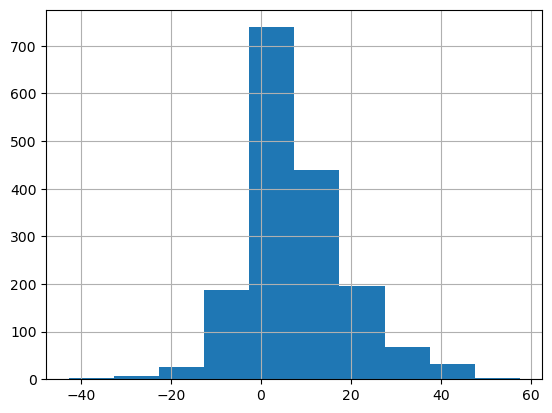

In [152]:
change_of_gl[0].hist()

In [146]:
decrease = change_of_gl[change_of_gl[0] < 10]
increase = change_of_gl[change_of_gl[0] > 10]

In [150]:
# increase.merge(bio_data[['PID', 'diabetes level']], on='PID', how='left').groupby('diabetes level').count()
decrease.merge(bio_data[['PID', 'diabetes level']], on='PID', how='left').groupby('diabetes level').count()

# decrease.groupby(['PID', 'diabetes level'])['Libre GL'].mean().reset_index()['diabetes level'].value_counts()

,Timestamp,Libre GL,HR,Calories (Activity),Intensity,Meal Type,Calories,Carbs,Protein,Fat,...,Amount Consumed,PID,METs,Amount Consumed,Sugar,Steps,RecordIndex,meal_index,id,0
diabetes level,,,,,,,,,,,,,,,,,,,,,
Diabetes,288,288,274,287,70,288,288,288,288,288,...,261,288,217,0,0,0,0,288,288,288
Normal,440,440,415,438,135,440,440,440,440,440,...,402,440,303,38,0,0,0,440,440,440
Prediabetes,364,364,348,352,28,364,364,364,364,364,...,354,364,336,0,28,12,12,364,364,364


In [141]:
increase.merge(bio_data[['PID', 'diabetes level']], on='PID', how='left').groupby(['PID', 'diabetes level'])['Libre GL'].mean().reset_index()['diabetes level'].value_counts()

Prediabetes    16
Normal         15
Diabetes       14
Name: diabetes level, dtype: int64

In [114]:
change_of_gl.columns

Index([          'Timestamp',            'Libre GL',                  'HR',
       'Calories (Activity)',           'Intensity',           'Meal Type',
                  'Calories',               'Carbs',             'Protein',
                       'Fat',               'Fiber',     'Amount Consumed',
                       'PID',                'METs',    'Amount Consumed ',
                     'Sugar',               'Steps',         'RecordIndex',
                'meal_index',                  'id',                     0],
      dtype='object')

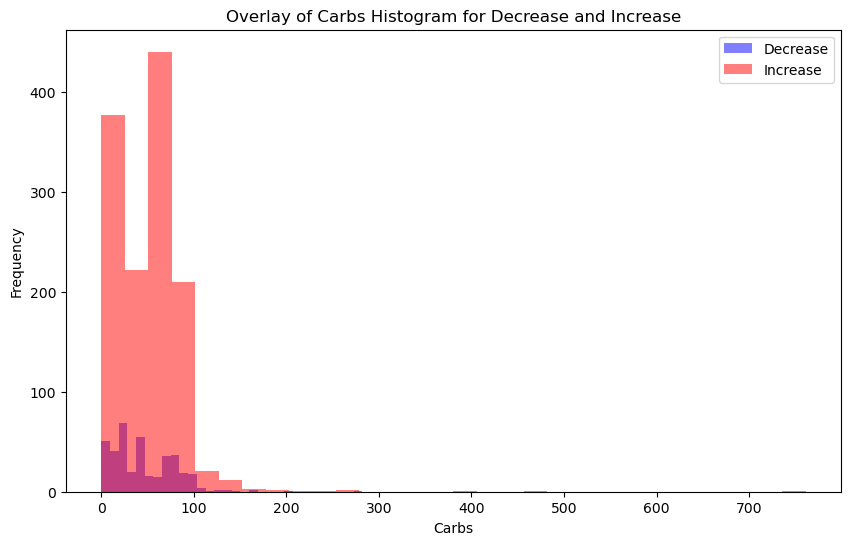

In [109]:
plt.figure(figsize=(10, 6))

# Plot histogram for decrease['Carbs']
plt.hist(decrease['Carbs'], bins=30, alpha=0.5, label='Decrease', color='blue')

# Plot histogram for increase['Carbs']
plt.hist(increase['Carbs'], bins=30, alpha=0.5, label='Increase', color='red')

plt.xlabel('Carbs')
plt.ylabel('Frequency')
plt.title('Overlay of Carbs Histogram for Decrease and Increase')
plt.legend()
plt.show()

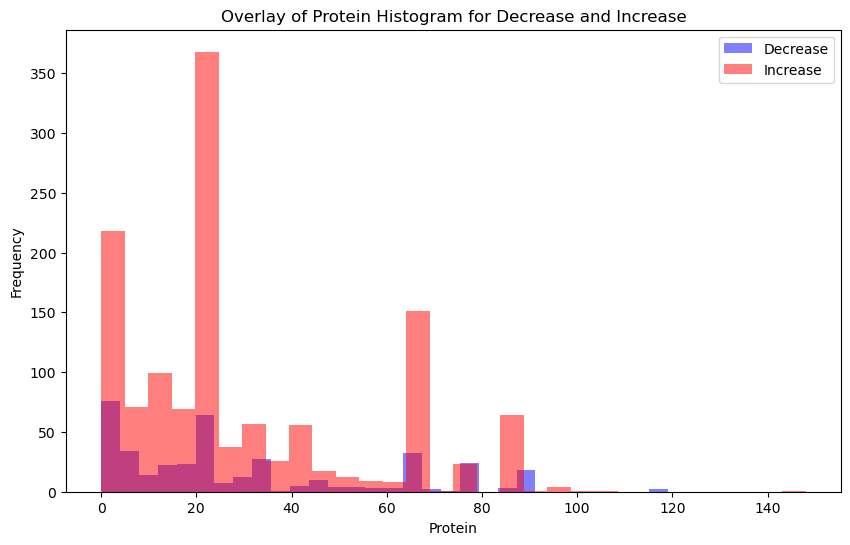

In [111]:
plt.figure(figsize=(10, 6))

# Plot histogram for decrease['Carbs']
plt.hist(decrease['Protein'], bins=30, alpha=0.5, label='Decrease', color='blue')

# Plot histogram for increase['Carbs']
plt.hist(increase['Protein'], bins=30, alpha=0.5, label='Increase', color='red')

plt.xlabel('Protein')
plt.ylabel('Frequency')
plt.title('Overlay of Protein Histogram for Decrease and Increase')
plt.legend()
plt.show()

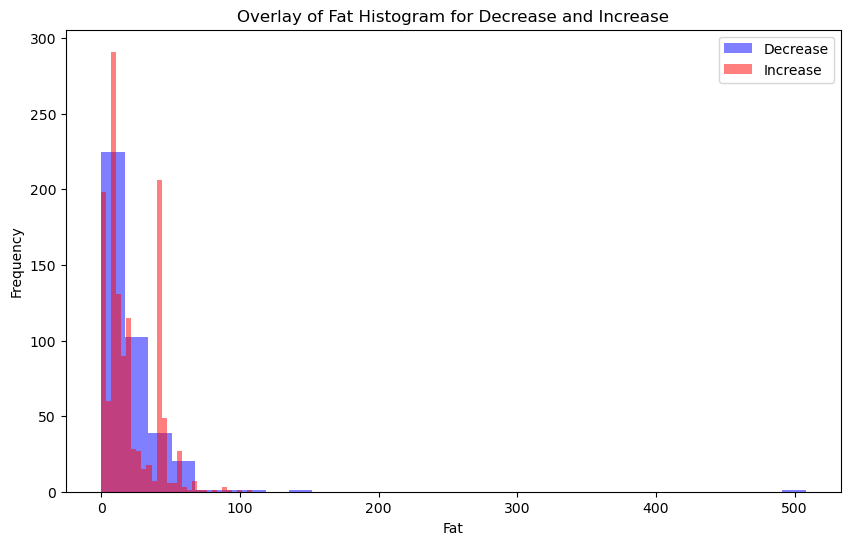

In [ ]:
plt.figure(figsize=(10, 6))

# Plot histogram for decrease['Carbs']
plt.hist(decrease['Fat'], bins=30, alpha=0.5, label='Decrease', color='blue')

# Plot histogram for increase['Carbs']
plt.hist(increase['Fat'], bins=30, alpha=0.5, label='Increase', color='red')

plt.xlabel('Fat')
plt.ylabel('Frequency')
plt.title('Overlay of Fat Histogram for Decrease and Increase')
plt.legend()
plt.show()

<AxesSubplot:>

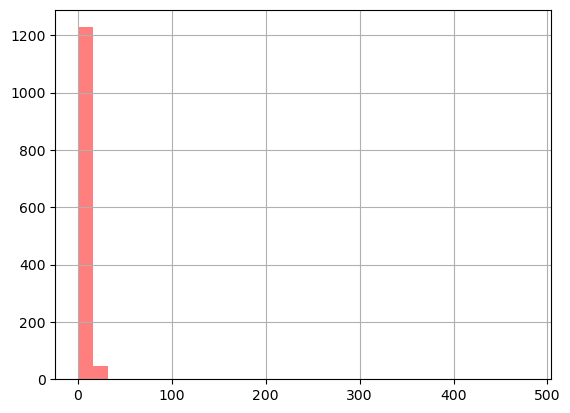

In [126]:
increase = increase[increase['Fiber'] < 500]
decrease = decrease[decrease['Fiber'] < 500]

increase['Fiber'].hist(bins=30, alpha=0.5, label='Increase', color='red')


<AxesSubplot:>

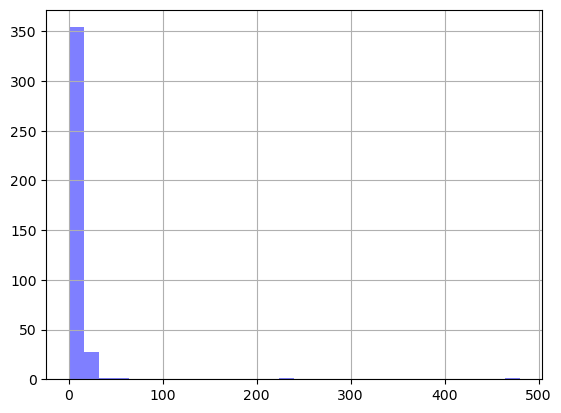

In [125]:
decrease['Fiber'].hist(bins=30, alpha=0.5, label='Decrease', color='blue')

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_23301/2841809058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['time_in_minutes'] = temp['Timestamp'].dt.total_seconds() / 60


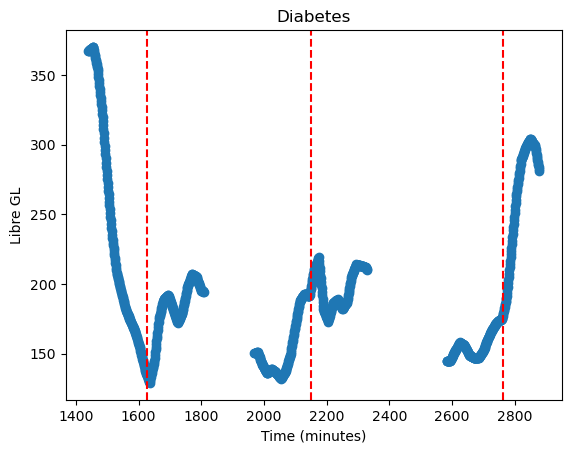

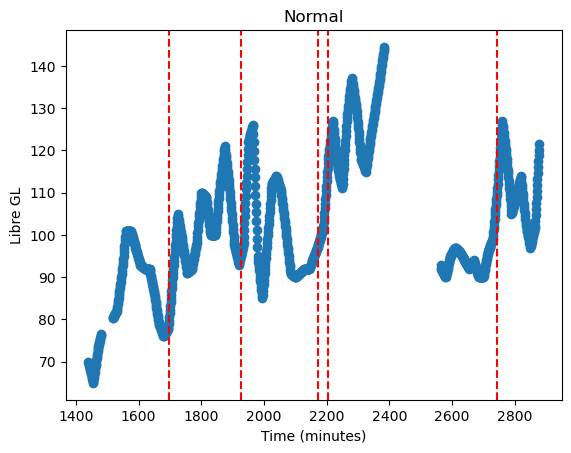

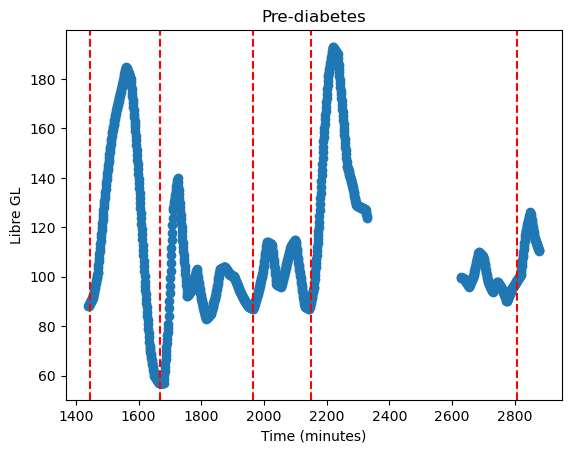

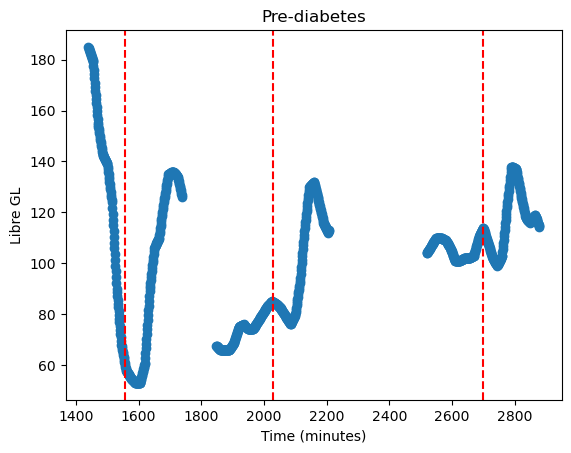

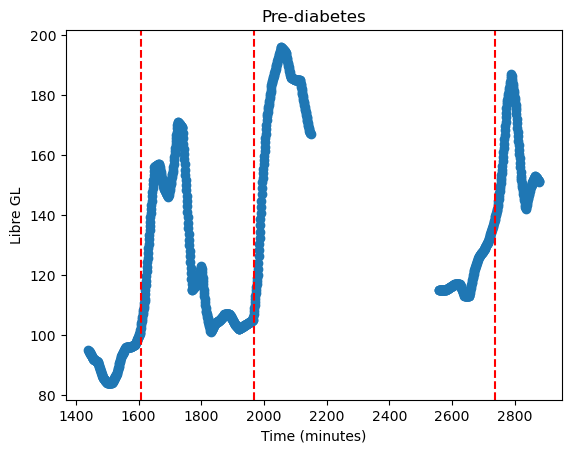

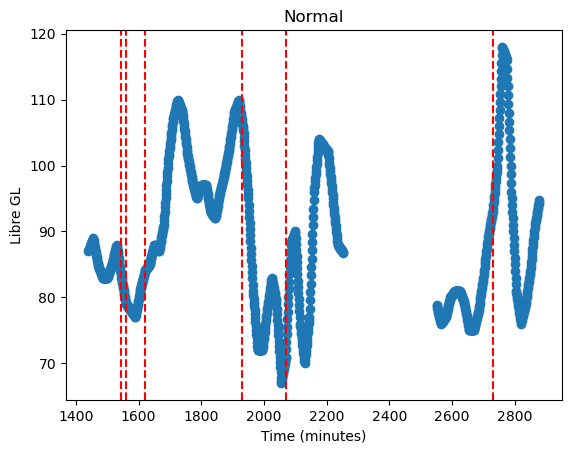

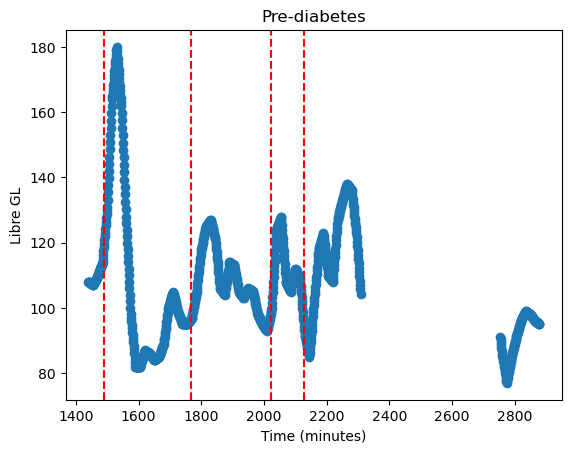

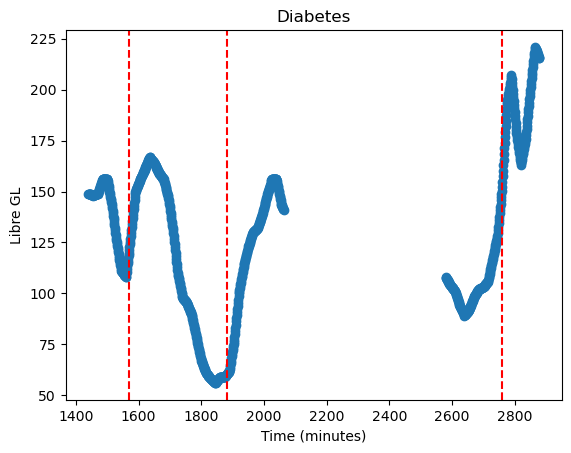

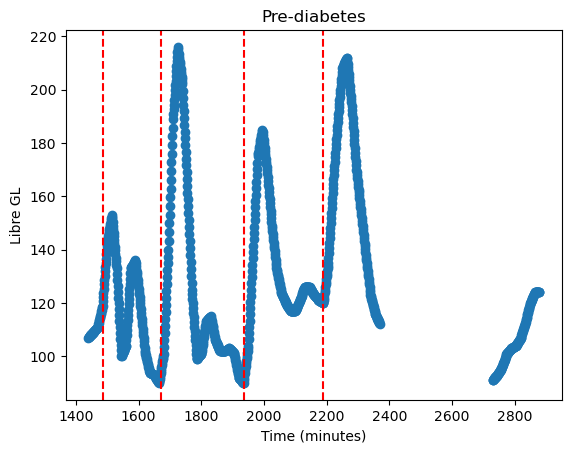

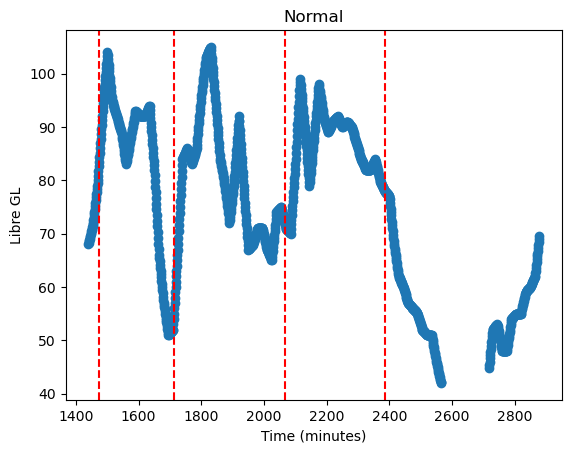

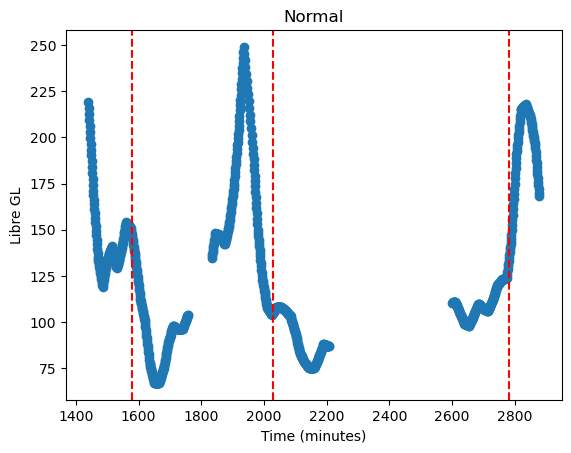

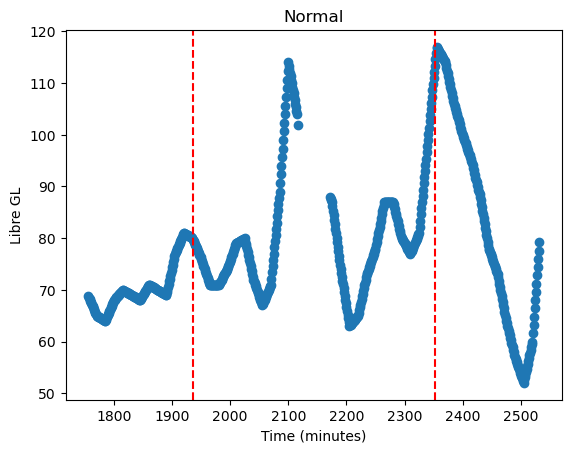

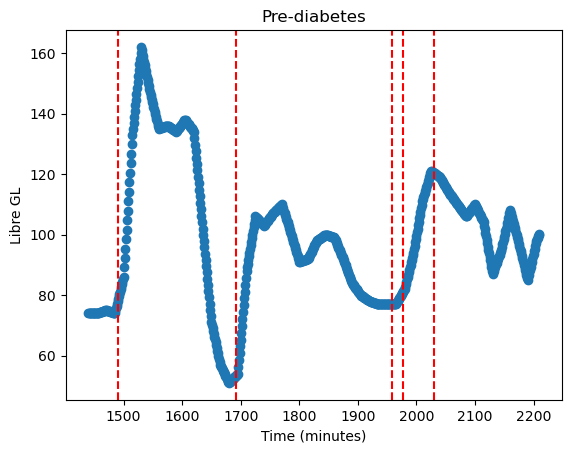

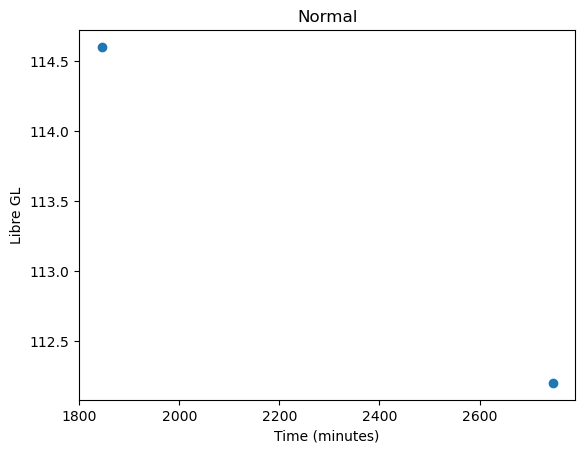

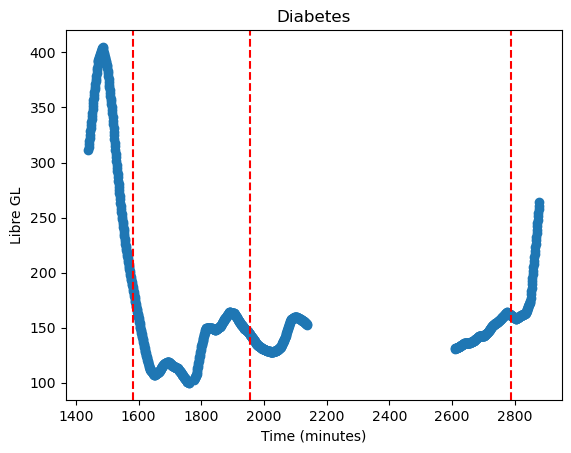

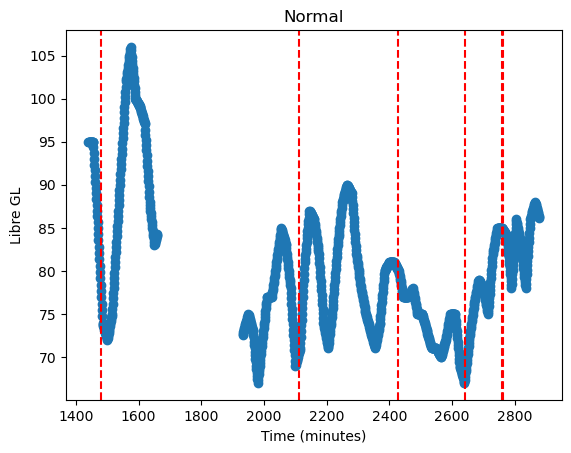

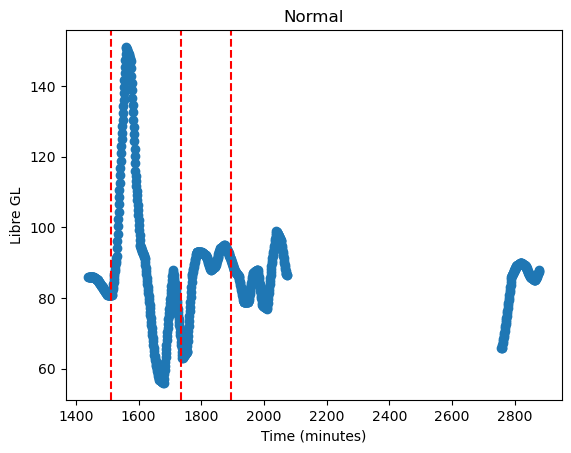

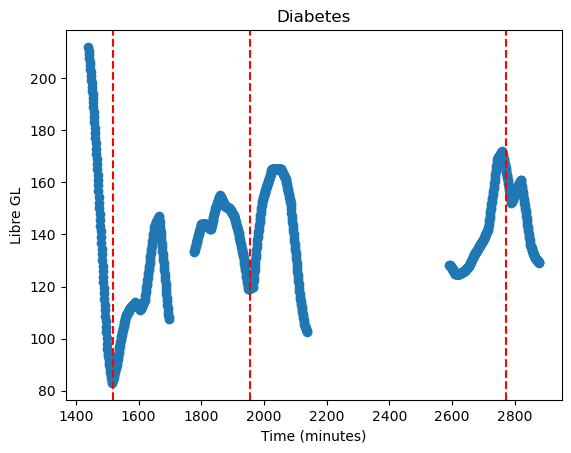

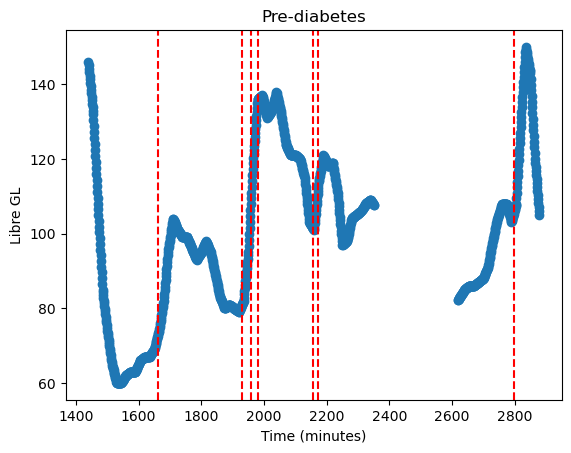

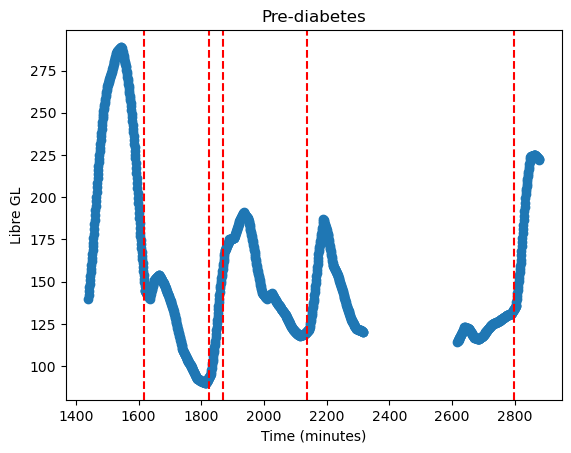

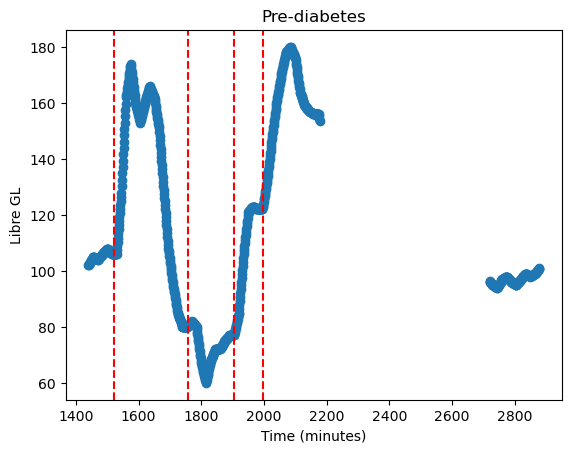

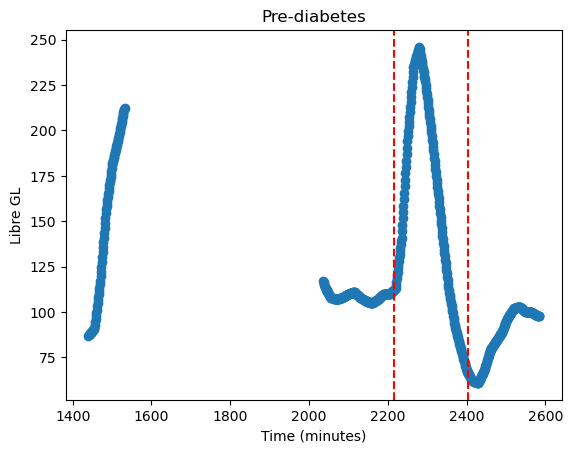

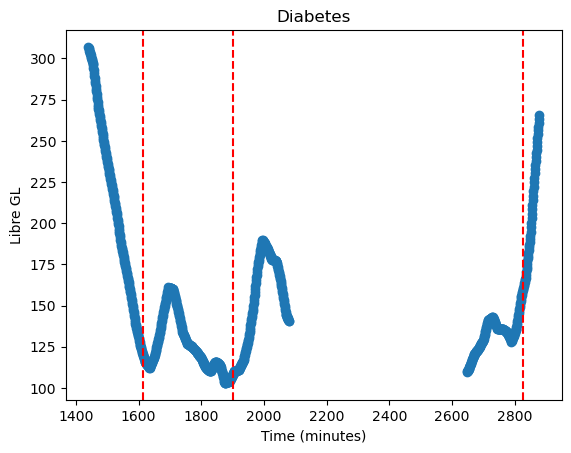

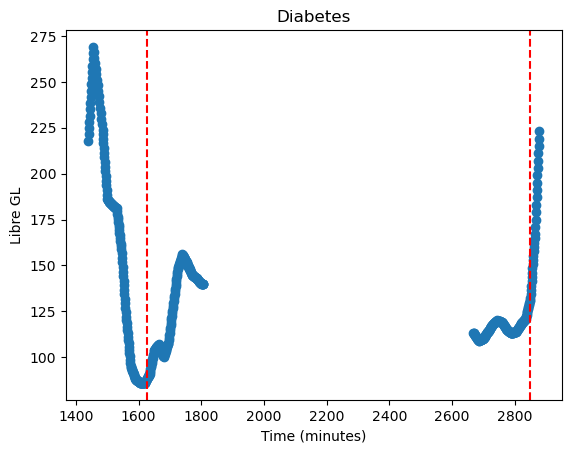

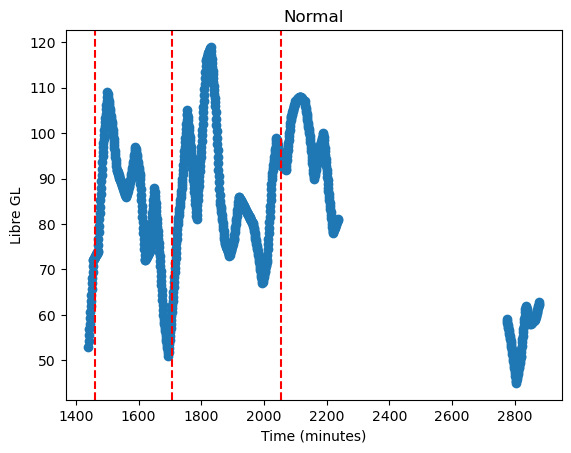

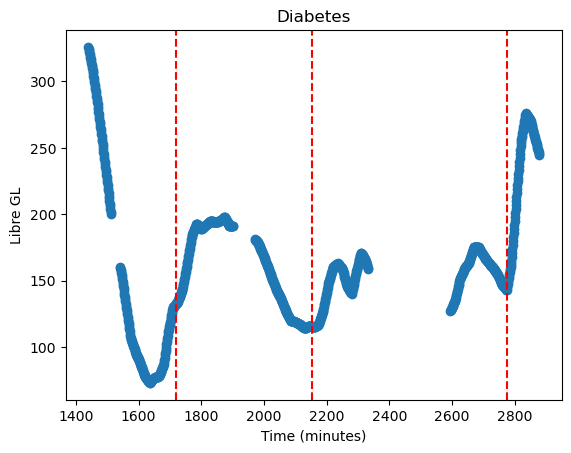

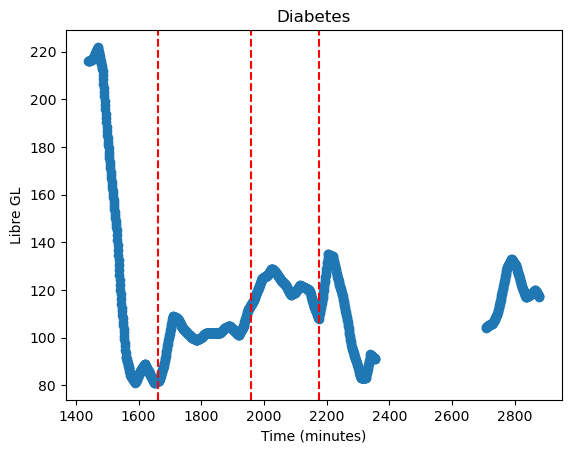

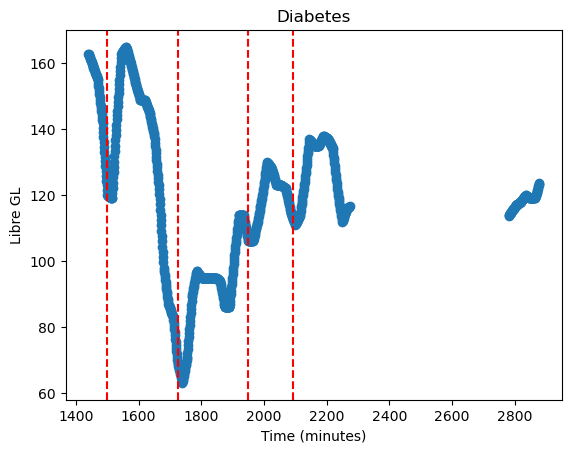

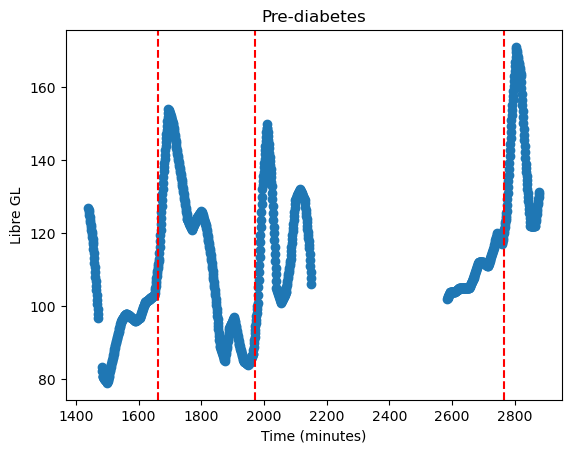

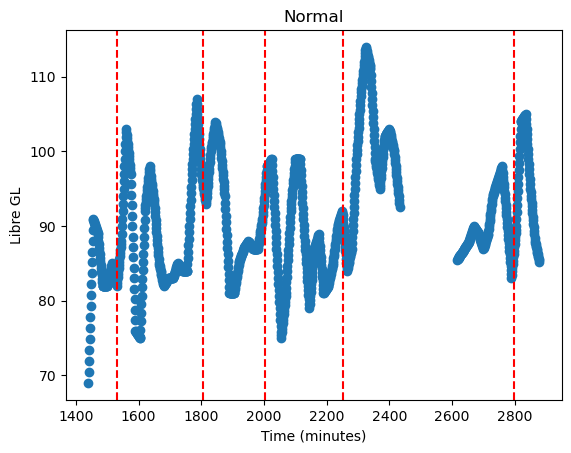

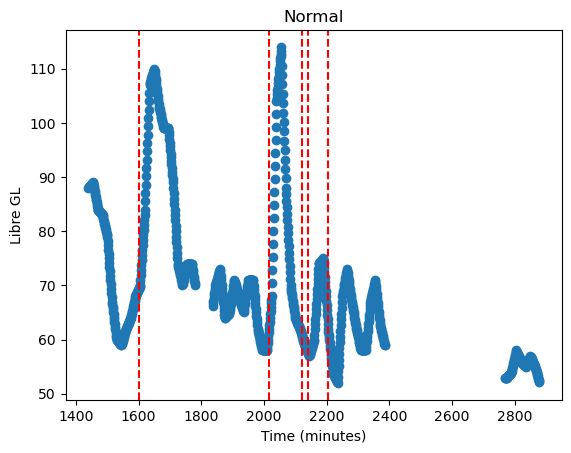

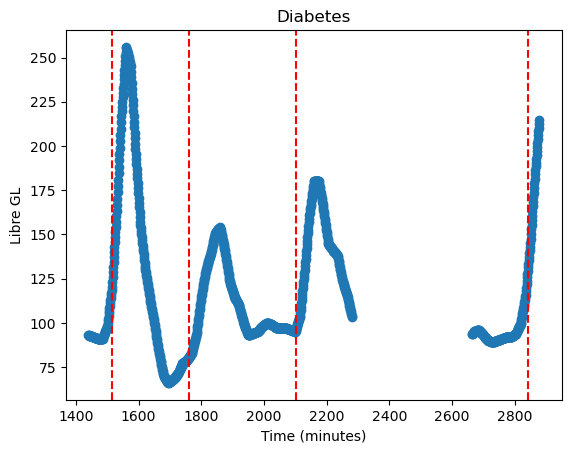

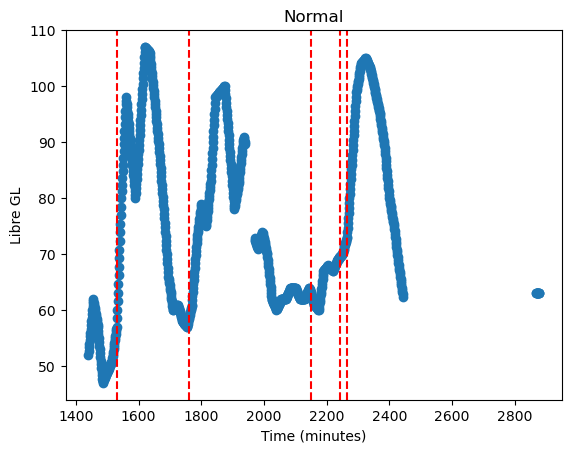

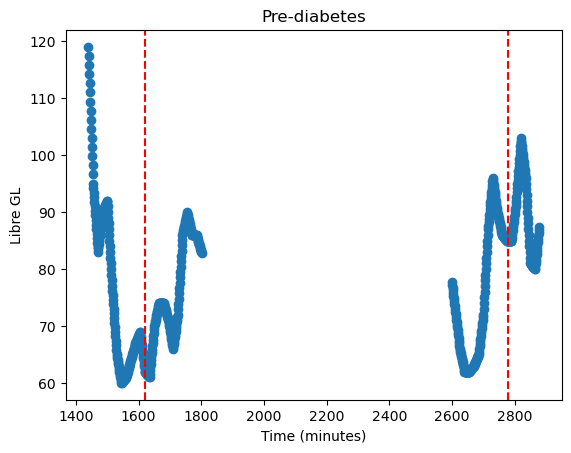

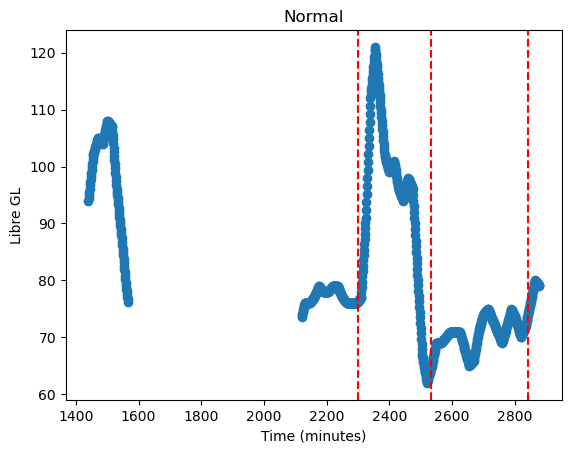

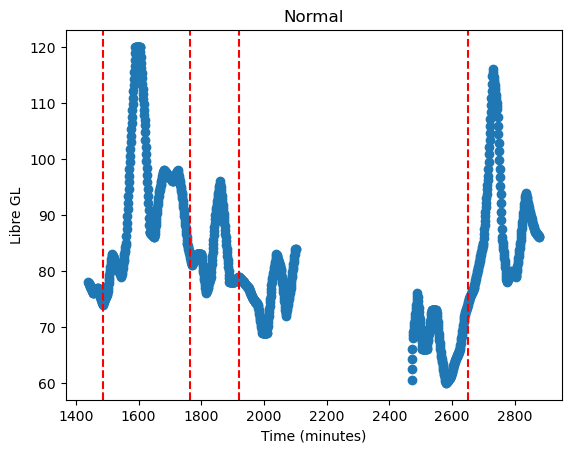

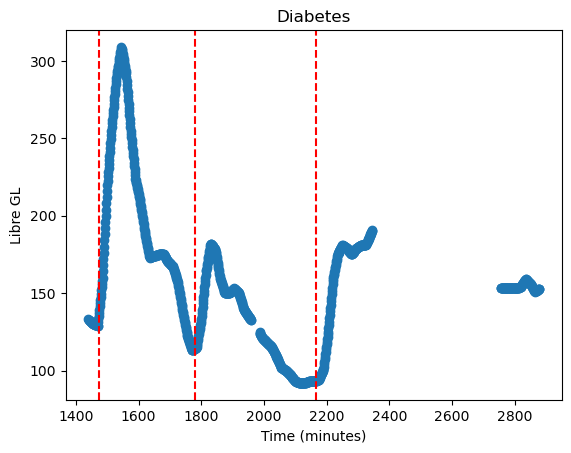

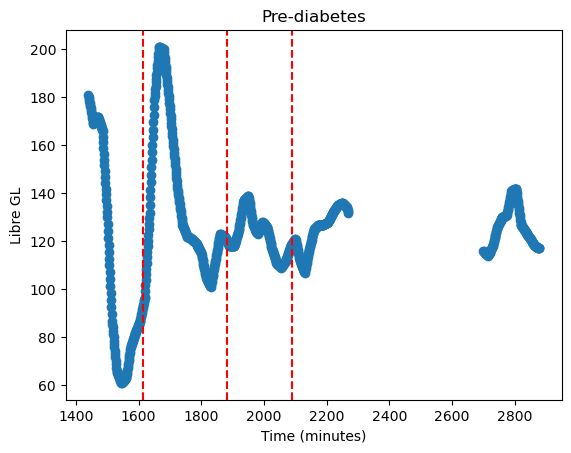

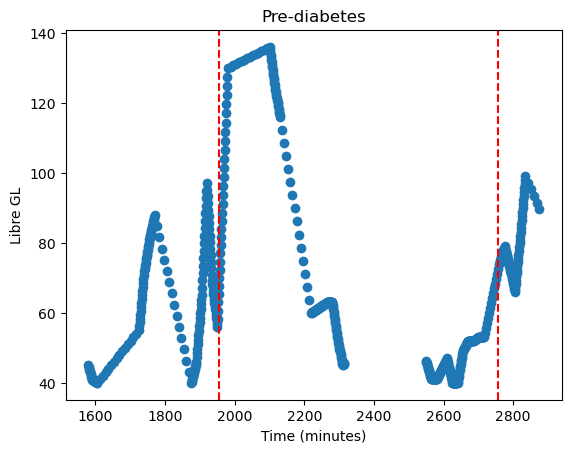

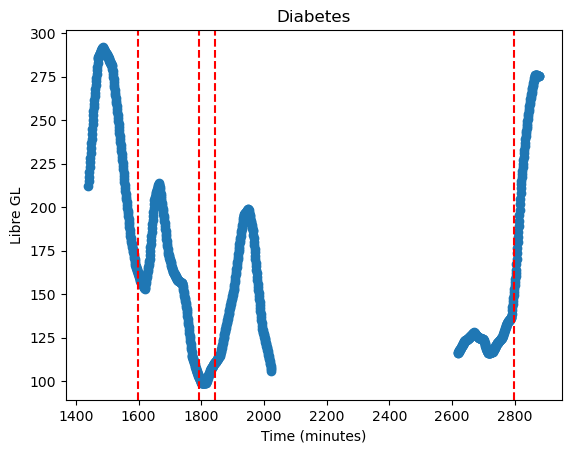

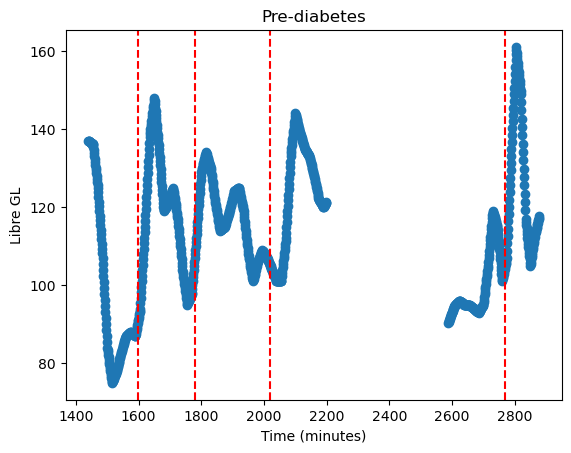

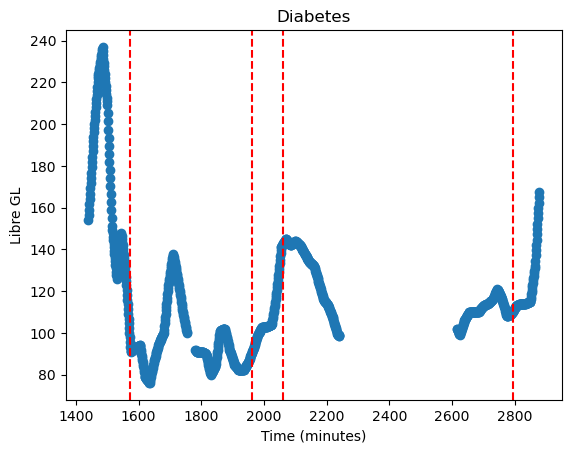

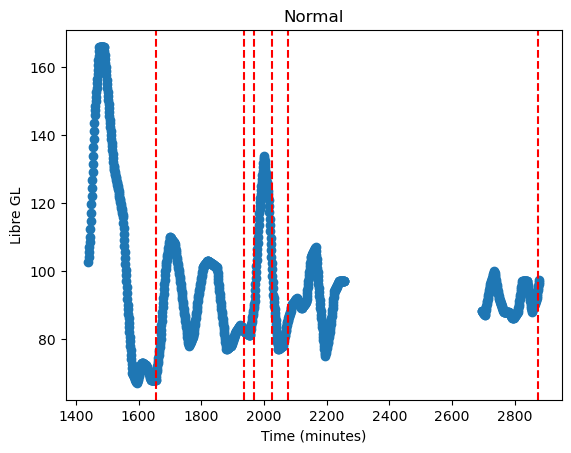

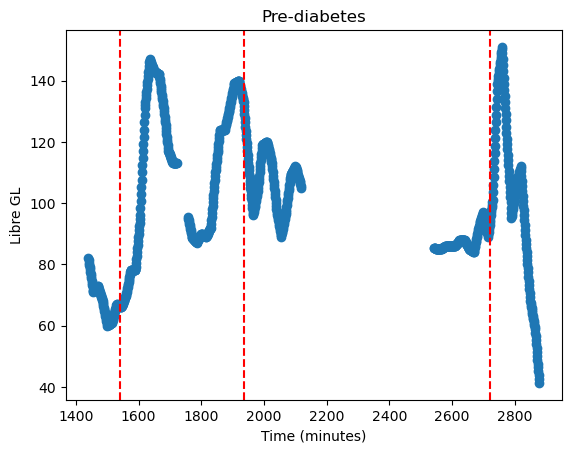

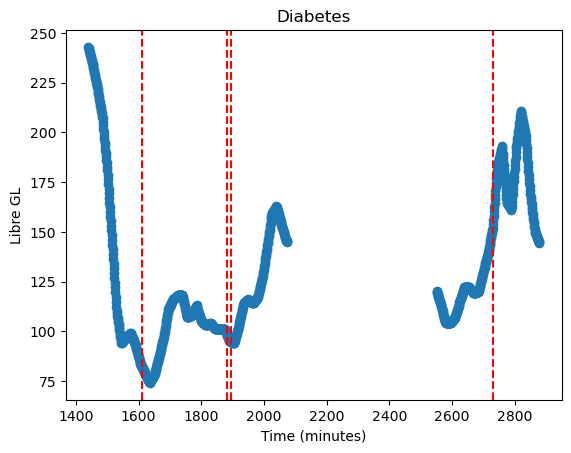

In [38]:
for PID in filtered_data.PID.unique():
    
    temp = filtered_data[(filtered_data['PID'] == PID) & (filtered_data['Timestamp'].dt.days == 1)]
    temp['time_in_minutes'] = temp['Timestamp'].dt.total_seconds() / 60

    # making a scatter plot
    plt.scatter(temp['time_in_minutes'], temp['Libre GL'])

    vertical_lines = temp[temp['Meal Type'].notnull()]['time_in_minutes']
    for vertical_line in vertical_lines:
        plt.axvline(x=vertical_line, color='r', linestyle='--')

    if PID in normal_group:
        plt.title('Normal')
    elif PID in pre_diabetes_group:
        plt.title('Pre-diabetes')
    else:
        plt.title('Diabetes')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Libre GL')
    plt.show()

In [140]:
# find the average calorize consumed by each PID in each type of meal


meals.groupby(['PID', 'Meal Type'])['Calories'].mean().reset_index().merge(bio_data[['PID', 'diabetes level']], on='PID', how='left').groupby(['diabetes level', 'Meal Type'])['Calories'].mean()

diabetes level  Meal Type
Diabetes        breakfast    576.058333
                dinner       388.995761
                lunch        680.488095
                snack        168.591957
Normal          breakfast    582.942222
                dinner       442.627334
                lunch        670.111111
                snack        221.439330
Prediabetes     breakfast    591.091667
                dinner       615.168182
                lunch        669.541667
                snack        221.647191
Name: Calories, dtype: float64

In [ ]:
all_data

KeyboardInterrupt: 

In [189]:
temp[temp['Meal Type'].notnull()]

,Timestamp,Libre GL,HR,Calories (Activity),Intensity,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,PID,METs,Amount Consumed,Sugar,Steps,RecordIndex
1628,1 days 03:08:00,133.666667,89.0,1.35356,0.0,lunch,830.0,92.0,17.0,42.0,10.0,100.0,35,NaN,NaN,NaN,NaN,NaN
2149,1 days 11:49:00,196.066667,106.0,7.08016,3.0,dinner,0.0,0.0,0.0,0.0,0.0,100.0,35,NaN,NaN,NaN,NaN,NaN
2763,1 days 22:03:00,178.200000,88.0,1.35356,0.0,breakfast,608.0,66.0,66.0,10.5,0.0,100.0,35,NaN,NaN,NaN,NaN,NaN


In [190]:
temp

,Timestamp,Libre GL,HR,Calories (Activity),Intensity,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,PID,METs,Amount Consumed,Sugar,Steps,RecordIndex
1440,1 days 00:00:00,367.000000,83.0,1.35356,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
1441,1 days 00:01:00,367.200000,81.0,1.35356,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
1442,1 days 00:02:00,367.400000,80.0,1.24944,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
1443,1 days 00:03:00,367.600000,78.0,1.35356,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
1444,1 days 00:04:00,367.800000,78.0,1.35356,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,1 days 23:55:00,286.333333,94.0,1.56180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
2876,1 days 23:56:00,285.066667,92.0,2.70712,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
2877,1 days 23:57:00,283.800000,93.0,3.33184,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN
2878,1 days 23:58:00,282.533333,98.0,1.56180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN


In [145]:
meal_data

,Timestamp,Libre GL,HR,Calories (Activity),Intensity,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,PID,METs,Amount Consumed,Sugar,Steps,RecordIndex
215,0 days 03:35:00,206.333333,NaN,1.04120,0.0,lunch,1180.0,81.0,88.0,54.5,18.0,100.0,35,NaN,NaN,NaN,NaN,NaN
1375,0 days 22:55:00,268.666667,88.0,1.35356,0.0,breakfast,448.0,66.0,22.0,10.5,0.0,100.0,35,NaN,NaN,NaN,NaN,NaN
1628,1 days 03:08:00,133.666667,89.0,1.35356,0.0,lunch,830.0,92.0,17.0,42.0,10.0,100.0,35,NaN,NaN,NaN,NaN,NaN
2149,1 days 11:49:00,196.066667,106.0,7.08016,3.0,dinner,0.0,0.0,0.0,0.0,0.0,100.0,35,NaN,NaN,NaN,NaN,NaN
2763,1 days 22:03:00,178.200000,88.0,1.35356,0.0,breakfast,608.0,66.0,66.0,10.5,0.0,100.0,35,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12861,8 days 22:21:00,122.200000,95.0,1.75335,0.0,breakfast,268.0,24.0,22.0,10.5,0.0,100.0,38,NaN,NaN,NaN,NaN,NaN
13087,9 days 02:07:00,82.533333,85.0,4.67560,1.0,lunch,725.0,94.0,44.0,20.0,4.0,100.0,38,NaN,NaN,NaN,NaN,NaN
13245,9 days 04:45:00,116.000000,101.0,5.02627,2.0,dinner,0.0,0.0,0.0,0.0,0.0,0.0,38,NaN,NaN,NaN,NaN,NaN
13423,9 days 07:43:00,107.266667,93.0,1.75335,0.0,dinner,277.0,55.0,11.0,1.0,2.0,100.0,38,NaN,NaN,NaN,NaN,NaN


In [58]:
diet_frequency.groupby('diabetes level').mean()

,PID,breakfast,dinner,lunch,snack
diabetes level,,,,,
Diabetes,30.285714,9.571429,8.928571,9.928571,4.071429
Normal,20.533333,9.866667,12.533333,9.800000,10.066667
Prediabetes,22.937500,9.625000,11.187500,9.312500,8.437500


In [59]:
temp

,Timestamp,Libre GL,HR,Calories (Activity),Intensity,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,PID,METs,Amount Consumed,Sugar,Steps,RecordIndex
215,0 days 03:35:00,206.333333,NaN,1.04120,0.0,lunch,1180.0,81.0,88.0,54.5,18.0,100.0,35,NaN,NaN,NaN,NaN,NaN
1375,0 days 22:55:00,268.666667,88.0,1.35356,0.0,breakfast,448.0,66.0,22.0,10.5,0.0,100.0,35,NaN,NaN,NaN,NaN,NaN
1628,1 days 03:08:00,133.666667,89.0,1.35356,0.0,lunch,830.0,92.0,17.0,42.0,10.0,100.0,35,NaN,NaN,NaN,NaN,NaN
2149,1 days 11:49:00,196.066667,106.0,7.08016,3.0,dinner,0.0,0.0,0.0,0.0,0.0,100.0,35,NaN,NaN,NaN,NaN,NaN
2763,1 days 22:03:00,178.200000,88.0,1.35356,0.0,breakfast,608.0,66.0,66.0,10.5,0.0,100.0,35,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12861,8 days 22:21:00,122.200000,95.0,1.75335,0.0,breakfast,268.0,24.0,22.0,10.5,0.0,100.0,38,NaN,NaN,NaN,NaN,NaN
13087,9 days 02:07:00,82.533333,85.0,4.67560,1.0,lunch,725.0,94.0,44.0,20.0,4.0,100.0,38,NaN,NaN,NaN,NaN,NaN
13245,9 days 04:45:00,116.000000,101.0,5.02627,2.0,dinner,0.0,0.0,0.0,0.0,0.0,0.0,38,NaN,NaN,NaN,NaN,NaN
13423,9 days 07:43:00,107.266667,93.0,1.75335,0.0,dinner,277.0,55.0,11.0,1.0,2.0,100.0,38,NaN,NaN,NaN,NaN,NaN


In [ ]:
# bio_data['A1c PDL (Lab)'].apply(categorize_starting_GLU).value_counts()

Prediabetes    16
Normal         15
Diabetes       14
Name: A1c PDL (Lab), dtype: int64

In [132]:
# declaimer: assume cal, nutrition calculated is correct

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-001.csv')
particpants_1_data

,Timestamp,Libre GL,Dexcom GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed
0,2020-05-01 10:30:00,84.000000,NaN,56.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-01 10:31:00,84.133333,NaN,56.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-01 10:32:00,84.266667,NaN,57.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-01 10:33:00,84.400000,NaN,54.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-01 10:34:00,84.533333,NaN,55.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14725,2020-05-11 15:55:00,81.666667,NaN,78.0,2.93552,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14726,2020-05-11 15:56:00,81.733333,NaN,79.0,3.14520,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14727,2020-05-11 15:57:00,81.800000,NaN,80.0,3.56456,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14728,2020-05-11 15:58:00,81.866667,NaN,81.0,3.56456,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
particpants_1_data_day_1[~particpants_1_data_day_1['Meal Type'].isna()]

,Timestamp,Libre GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed
233,0 days 03:53:00,69.8,95.0,4.61296,44.0,Lunch,1170.0,85.0,88.0,54.2,12.0,100.0
618,0 days 10:18:00,84.8,81.0,1.36292,13.0,Dinner,80.0,18.0,0.0,0.0,0.0,100.0
825,0 days 13:45:00,81.0,78.0,4.40328,42.0,Snacks,110.0,24.0,0.0,2.0,0.0,100.0
1308,0 days 21:48:00,88.4,81.0,3.14520,30.0,Breakfast,448.0,66.0,22.0,10.5,0.0,100.0


In [130]:
particpants_1_data_day_2[~particpants_1_data_day_2['Meal Type'].isna()]

,Timestamp,Libre GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed
1530,1 days 01:30:00,82.000000,84.0,2.93552,28.0,Lunch,840.0,89.0,17.0,42.0,3.0,100.0
1807,1 days 06:07:00,95.133333,81.0,2.93552,28.0,Snacks,38.0,9.0,0.0,0.0,0.0,100.0
2002,1 days 09:22:00,94.266667,88.0,3.56456,34.0,Dinner,330.0,32.0,4.0,22.0,4.0,100.0
2253,1 days 13:33:00,90.400000,81.0,1.36292,13.0,Snacks,160.0,29.0,2.0,4.0,0.0,100.0
2797,1 days 22:37:00,86.266667,93.0,1.57260,15.0,Breakfast,608.0,66.0,66.0,10.5,0.0,100.0


In [131]:
particpants_1_data_day_3[~particpants_1_data_day_3['Meal Type'].isna()]

,Timestamp,Libre GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed
3141,2 days 04:21:00,79.0,96.0,2.72584,26.0,Lunch,615.0,26.0,67.0,30.0,3.0,100.0
3452,2 days 09:32:00,79.6,88.0,3.56456,34.0,Dinner,240.0,28.0,9.0,10.0,3.0,100.0
3498,2 days 10:18:00,89.0,106.0,4.61296,44.0,Snacks,90.0,22.0,1.0,0.0,0.0,100.0
3596,2 days 11:56:00,97.4,89.0,3.14520,30.0,Snacks,107.0,11.0,7.0,3.0,0.0,100.0
4247,2 days 22:47:00,88.0,92.0,6.91944,66.0,Breakfast,712.0,66.0,22.0,42.0,0.0,100.0


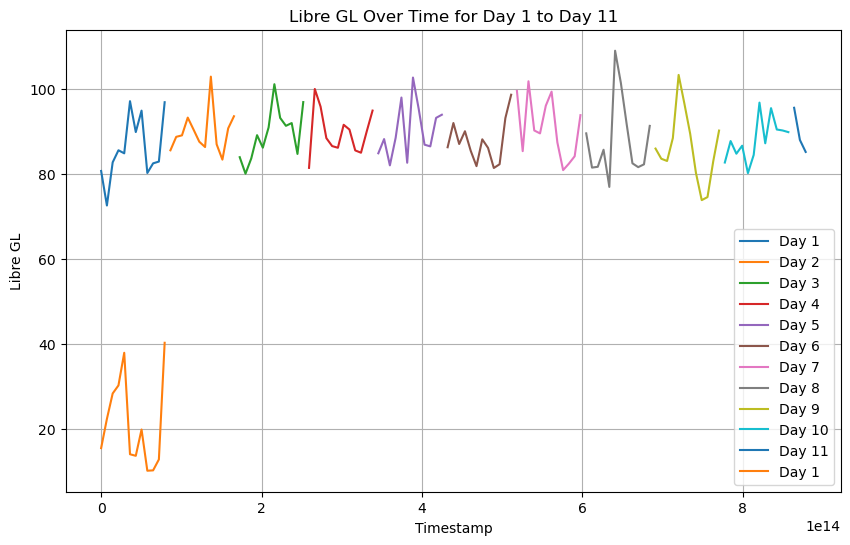

In [124]:
# Libre GL
# reset the time



# find the actual Calories and nutrions based on the percentage of amount consumed

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-001.csv')
particpants_1_data['Timestamp'] = pd.to_datetime(particpants_1_data['Timestamp'])
# reset the time by subtracting the first time
particpants_1_data['Timestamp'] = particpants_1_data['Timestamp'] - particpants_1_data['Timestamp'][0]

# drop Dexcom GL column
particpants_1_data = particpants_1_data.drop(columns=['Dexcom GL'])

# only look at the data in day 1
particpants_1_data_day_1 = particpants_1_data[particpants_1_data['Timestamp'] < pd.Timedelta('1 days')]

# only look at the data in day 2
particpants_1_data_day_2 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('1 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('2 days'))]

# only look at the data in day 3
particpants_1_data_day_3 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('2 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('3 days'))]

# only look at the data in day 4
particpants_1_data_day_4 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('3 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('4 days'))]

# only look at the data in day 5
particpants_1_data_day_5 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('4 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('5 days'))]

# only look at the data in day 6
particpants_1_data_day_6 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('5 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('6 days'))]

# only look at the data in day 7
particpants_1_data_day_7 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('6 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('7 days'))]

# only look at the data in day 8
particpants_1_data_day_8 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('7 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('8 days'))]

# only look at the data in day 9
particpants_1_data_day_9 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('8 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('9 days'))]

# only look at the data in day 10
particpants_1_data_day_10 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('9 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('10 days'))]

# only look at the data in day 11
particpants_1_data_day_11 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('10 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('11 days'))]

# combine time stamps into 10 mins interval and only keep the column Timestamp and Libre GL and drop the rest
particpants_1_data_day1_agg = particpants_1_data_day_1.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day2_agg = particpants_1_data_day_2.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day3_agg = particpants_1_data_day_3.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day4_agg = particpants_1_data_day_4.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day5_agg = particpants_1_data_day_5.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day6_agg = particpants_1_data_day_6.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day7_agg = particpants_1_data_day_7.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day8_agg = particpants_1_data_day_8.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day9_agg = particpants_1_data_day_9.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day10_agg = particpants_1_data_day_10.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()
particpants_1_data_day11_agg = particpants_1_data_day_11.groupby(pd.Grouper(key='Timestamp', freq='120T'))['Libre GL'].mean().reset_index()

# plot the eleven days overlapping on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['Libre GL'], label='Day 1')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['Libre GL'], label='Day 2')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['Libre GL'], label='Day 3')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['Libre GL'], label='Day 4')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['Libre GL'], label='Day 5')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['Libre GL'], label='Day 6')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['Libre GL'], label='Day 7')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['Libre GL'], label='Day 8')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['Libre GL'], label='Day 9')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['Libre GL'], label='Day 10')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['Libre GL'], label='Day 11')

plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['METs'], label='Day 1')

plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.title('Libre GL Over Time for Day 1 to Day 11')
plt.legend()
plt.grid(True)
plt.show()


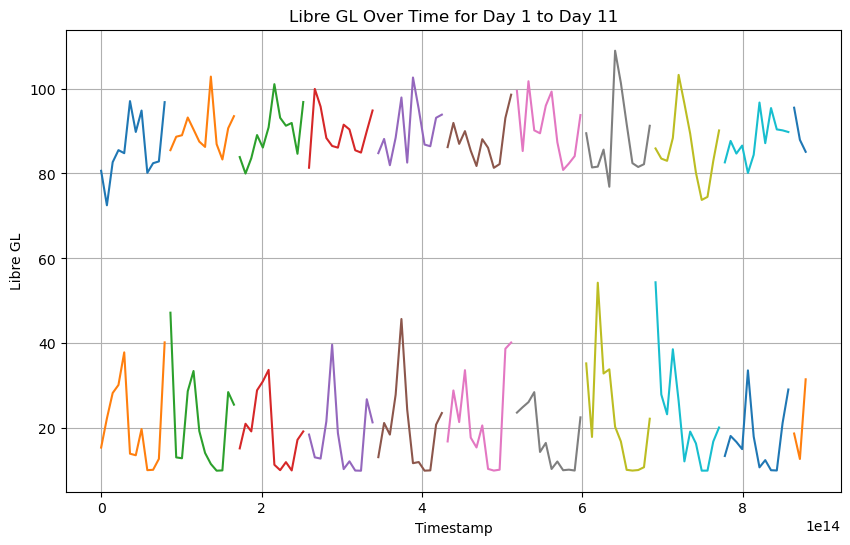

In [111]:
# Libre GL
# reset the time
# find the actual Calories and nutrions based on the percentage of amount consumed

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-001.csv')
particpants_1_data['Timestamp'] = pd.to_datetime(particpants_1_data['Timestamp'])
# reset the time by subtracting the first time
particpants_1_data['Timestamp'] = particpants_1_data['Timestamp'] - particpants_1_data['Timestamp'][0]

# drop Dexcom GL column
particpants_1_data = particpants_1_data.drop(columns=['Dexcom GL'])

# only look at the data in day 1
particpants_1_data_day_1 = particpants_1_data[particpants_1_data['Timestamp'] < pd.Timedelta('1 days')]

# only look at the data in day 2
particpants_1_data_day_2 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('1 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('2 days'))]

# only look at the data in day 3
particpants_1_data_day_3 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('2 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('3 days'))]

# only look at the data in day 4
particpants_1_data_day_4 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('3 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('4 days'))]

# only look at the data in day 5
particpants_1_data_day_5 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('4 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('5 days'))]

# only look at the data in day 6
particpants_1_data_day_6 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('5 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('6 days'))]

# only look at the data in day 7
particpants_1_data_day_7 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('6 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('7 days'))]

# only look at the data in day 8
particpants_1_data_day_8 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('7 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('8 days'))]

# only look at the data in day 9
particpants_1_data_day_9 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('8 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('9 days'))]

# only look at the data in day 10
particpants_1_data_day_10 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('9 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('10 days'))]

# only look at the data in day 11
particpants_1_data_day_11 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('10 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('11 days'))]

# combine time stamps into 10 mins interval and only keep the column Timestamp and Libre GL and drop the rest
particpants_1_data_day1_agg = particpants_1_data_day_1.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day2_agg = particpants_1_data_day_2.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day3_agg = particpants_1_data_day_3.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day4_agg = particpants_1_data_day_4.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day5_agg = particpants_1_data_day_5.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day6_agg = particpants_1_data_day_6.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day7_agg = particpants_1_data_day_7.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day8_agg = particpants_1_data_day_8.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day9_agg = particpants_1_data_day_9.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day10_agg = particpants_1_data_day_10.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day11_agg = particpants_1_data_day_11.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()

# plot the eleven days overlapping on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['Libre GL'], label='Day 1')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['Libre GL'], label='Day 2')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['Libre GL'], label='Day 3')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['Libre GL'], label='Day 4')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['Libre GL'], label='Day 5')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['Libre GL'], label='Day 6')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['Libre GL'], label='Day 7')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['Libre GL'], label='Day 8')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['Libre GL'], label='Day 9')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['Libre GL'], label='Day 10')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['Libre GL'], label='Day 11')

plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['METs'], label='Day 1 METs')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['METs'], label='Day 2 METs')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['METs'], label='Day 3 METs')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['METs'], label='Day 4 METs')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['METs'], label='Day 5 METs')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['METs'], label='Day 6 METs')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['METs'], label='Day 7 METs')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['METs'], label='Day 8 METs')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['METs'], label='Day 9 METs')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['METs'], label='Day 10 METs')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['METs'], label='Day 11 METs')

plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.title('Libre GL Over Time for Day 1 to Day 11')
# plt.legend()
plt.grid(True)
plt.show()


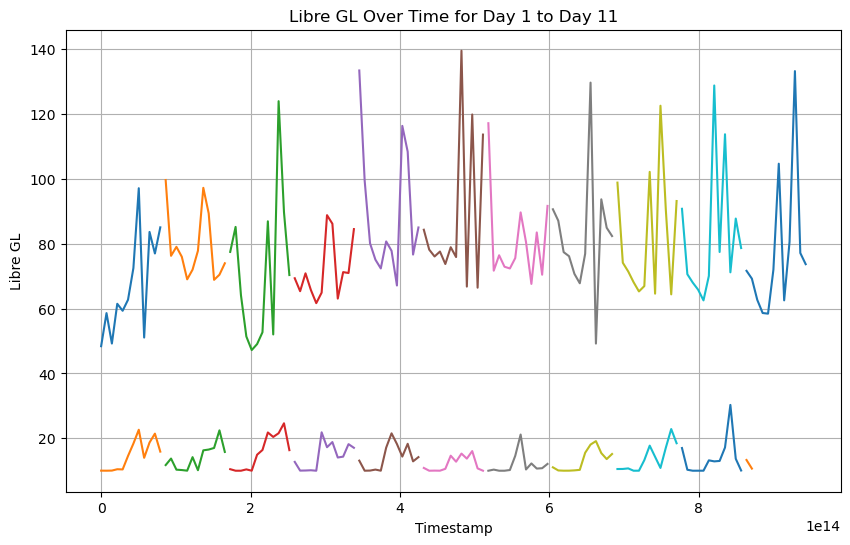

In [112]:
# Libre GL
# reset the time
# find the actual Calories and nutrions based on the percentage of amount consumed

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-002.csv')
particpants_1_data['Timestamp'] = pd.to_datetime(particpants_1_data['Timestamp'])
# reset the time by subtracting the first time
particpants_1_data['Timestamp'] = particpants_1_data['Timestamp'] - particpants_1_data['Timestamp'][0]

# drop Dexcom GL column
particpants_1_data = particpants_1_data.drop(columns=['Dexcom GL'])

# only look at the data in day 1
particpants_1_data_day_1 = particpants_1_data[particpants_1_data['Timestamp'] < pd.Timedelta('1 days')]

# only look at the data in day 2
particpants_1_data_day_2 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('1 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('2 days'))]

# only look at the data in day 3
particpants_1_data_day_3 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('2 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('3 days'))]

# only look at the data in day 4
particpants_1_data_day_4 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('3 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('4 days'))]

# only look at the data in day 5
particpants_1_data_day_5 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('4 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('5 days'))]

# only look at the data in day 6
particpants_1_data_day_6 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('5 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('6 days'))]

# only look at the data in day 7
particpants_1_data_day_7 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('6 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('7 days'))]

# only look at the data in day 8
particpants_1_data_day_8 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('7 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('8 days'))]

# only look at the data in day 9
particpants_1_data_day_9 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('8 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('9 days'))]

# only look at the data in day 10
particpants_1_data_day_10 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('9 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('10 days'))]

# only look at the data in day 11
particpants_1_data_day_11 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('10 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('11 days'))]

# combine time stamps into 10 mins interval and only keep the column Timestamp and Libre GL and drop the rest
particpants_1_data_day1_agg = particpants_1_data_day_1.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day2_agg = particpants_1_data_day_2.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day3_agg = particpants_1_data_day_3.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day4_agg = particpants_1_data_day_4.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day5_agg = particpants_1_data_day_5.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day6_agg = particpants_1_data_day_6.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day7_agg = particpants_1_data_day_7.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day8_agg = particpants_1_data_day_8.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day9_agg = particpants_1_data_day_9.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day10_agg = particpants_1_data_day_10.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day11_agg = particpants_1_data_day_11.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()

# plot the eleven days overlapping on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['Libre GL'], label='Day 1')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['Libre GL'], label='Day 2')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['Libre GL'], label='Day 3')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['Libre GL'], label='Day 4')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['Libre GL'], label='Day 5')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['Libre GL'], label='Day 6')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['Libre GL'], label='Day 7')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['Libre GL'], label='Day 8')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['Libre GL'], label='Day 9')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['Libre GL'], label='Day 10')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['Libre GL'], label='Day 11')

plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['METs'], label='Day 1 METs')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['METs'], label='Day 2 METs')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['METs'], label='Day 3 METs')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['METs'], label='Day 4 METs')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['METs'], label='Day 5 METs')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['METs'], label='Day 6 METs')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['METs'], label='Day 7 METs')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['METs'], label='Day 8 METs')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['METs'], label='Day 9 METs')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['METs'], label='Day 10 METs')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['METs'], label='Day 11 METs')

plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.title('Libre GL Over Time for Day 1 to Day 11')
# plt.legend()
plt.grid(True)
plt.show()


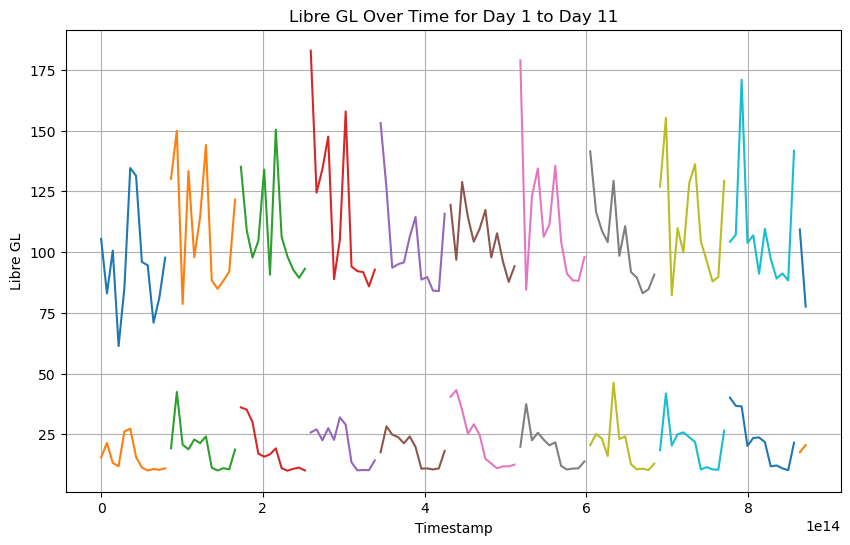

In [113]:
# Libre GL
# reset the time
# find the actual Calories and nutrions based on the percentage of amount consumed

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-003.csv')
particpants_1_data['Timestamp'] = pd.to_datetime(particpants_1_data['Timestamp'])
# reset the time by subtracting the first time
particpants_1_data['Timestamp'] = particpants_1_data['Timestamp'] - particpants_1_data['Timestamp'][0]

# drop Dexcom GL column
particpants_1_data = particpants_1_data.drop(columns=['Dexcom GL'])

# only look at the data in day 1
particpants_1_data_day_1 = particpants_1_data[particpants_1_data['Timestamp'] < pd.Timedelta('1 days')]

# only look at the data in day 2
particpants_1_data_day_2 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('1 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('2 days'))]

# only look at the data in day 3
particpants_1_data_day_3 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('2 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('3 days'))]

# only look at the data in day 4
particpants_1_data_day_4 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('3 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('4 days'))]

# only look at the data in day 5
particpants_1_data_day_5 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('4 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('5 days'))]

# only look at the data in day 6
particpants_1_data_day_6 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('5 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('6 days'))]

# only look at the data in day 7
particpants_1_data_day_7 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('6 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('7 days'))]

# only look at the data in day 8
particpants_1_data_day_8 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('7 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('8 days'))]

# only look at the data in day 9
particpants_1_data_day_9 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('8 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('9 days'))]

# only look at the data in day 10
particpants_1_data_day_10 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('9 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('10 days'))]

# only look at the data in day 11
particpants_1_data_day_11 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('10 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('11 days'))]

# combine time stamps into 10 mins interval and only keep the column Timestamp and Libre GL and drop the rest
particpants_1_data_day1_agg = particpants_1_data_day_1.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day2_agg = particpants_1_data_day_2.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day3_agg = particpants_1_data_day_3.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day4_agg = particpants_1_data_day_4.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day5_agg = particpants_1_data_day_5.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day6_agg = particpants_1_data_day_6.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day7_agg = particpants_1_data_day_7.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day8_agg = particpants_1_data_day_8.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day9_agg = particpants_1_data_day_9.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day10_agg = particpants_1_data_day_10.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day11_agg = particpants_1_data_day_11.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()

# plot the eleven days overlapping on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['Libre GL'], label='Day 1')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['Libre GL'], label='Day 2')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['Libre GL'], label='Day 3')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['Libre GL'], label='Day 4')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['Libre GL'], label='Day 5')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['Libre GL'], label='Day 6')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['Libre GL'], label='Day 7')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['Libre GL'], label='Day 8')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['Libre GL'], label='Day 9')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['Libre GL'], label='Day 10')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['Libre GL'], label='Day 11')

plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['METs'], label='Day 1 METs')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['METs'], label='Day 2 METs')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['METs'], label='Day 3 METs')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['METs'], label='Day 4 METs')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['METs'], label='Day 5 METs')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['METs'], label='Day 6 METs')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['METs'], label='Day 7 METs')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['METs'], label='Day 8 METs')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['METs'], label='Day 9 METs')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['METs'], label='Day 10 METs')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['METs'], label='Day 11 METs')

plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.title('Libre GL Over Time for Day 1 to Day 11')
# plt.legend()
plt.grid(True)
plt.show()


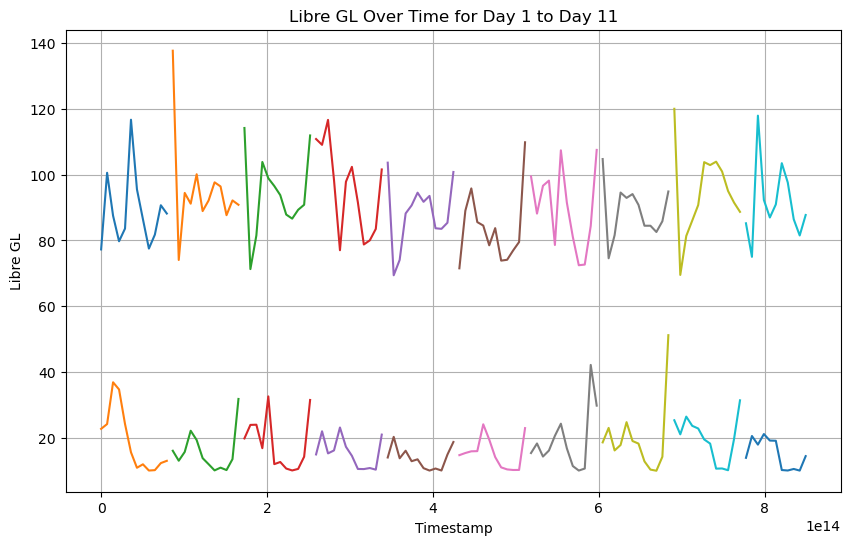

In [115]:
# Libre GL
# reset the time
# find the actual Calories and nutrions based on the percentage of amount consumed

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-004.csv')
particpants_1_data['Timestamp'] = pd.to_datetime(particpants_1_data['Timestamp'])
# reset the time by subtracting the first time
particpants_1_data['Timestamp'] = particpants_1_data['Timestamp'] - particpants_1_data['Timestamp'][0]

# drop Dexcom GL column
particpants_1_data = particpants_1_data.drop(columns=['Dexcom GL'])

# only look at the data in day 1
particpants_1_data_day_1 = particpants_1_data[particpants_1_data['Timestamp'] < pd.Timedelta('1 days')]

# only look at the data in day 2
particpants_1_data_day_2 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('1 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('2 days'))]

# only look at the data in day 3
particpants_1_data_day_3 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('2 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('3 days'))]

# only look at the data in day 4
particpants_1_data_day_4 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('3 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('4 days'))]

# only look at the data in day 5
particpants_1_data_day_5 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('4 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('5 days'))]

# only look at the data in day 6
particpants_1_data_day_6 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('5 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('6 days'))]

# only look at the data in day 7
particpants_1_data_day_7 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('6 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('7 days'))]

# only look at the data in day 8
particpants_1_data_day_8 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('7 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('8 days'))]

# only look at the data in day 9
particpants_1_data_day_9 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('8 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('9 days'))]

# only look at the data in day 10
particpants_1_data_day_10 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('9 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('10 days'))]

# only look at the data in day 11
particpants_1_data_day_11 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('10 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('11 days'))]

# combine time stamps into 10 mins interval and only keep the column Timestamp and Libre GL and drop the rest
particpants_1_data_day1_agg = particpants_1_data_day_1.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day2_agg = particpants_1_data_day_2.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day3_agg = particpants_1_data_day_3.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day4_agg = particpants_1_data_day_4.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day5_agg = particpants_1_data_day_5.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day6_agg = particpants_1_data_day_6.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day7_agg = particpants_1_data_day_7.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day8_agg = particpants_1_data_day_8.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day9_agg = particpants_1_data_day_9.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day10_agg = particpants_1_data_day_10.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day11_agg = particpants_1_data_day_11.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()

# plot the eleven days overlapping on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['Libre GL'], label='Day 1')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['Libre GL'], label='Day 2')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['Libre GL'], label='Day 3')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['Libre GL'], label='Day 4')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['Libre GL'], label='Day 5')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['Libre GL'], label='Day 6')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['Libre GL'], label='Day 7')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['Libre GL'], label='Day 8')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['Libre GL'], label='Day 9')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['Libre GL'], label='Day 10')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['Libre GL'], label='Day 11')

plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['METs'], label='Day 1 METs')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['METs'], label='Day 2 METs')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['METs'], label='Day 3 METs')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['METs'], label='Day 4 METs')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['METs'], label='Day 5 METs')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['METs'], label='Day 6 METs')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['METs'], label='Day 7 METs')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['METs'], label='Day 8 METs')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['METs'], label='Day 9 METs')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['METs'], label='Day 10 METs')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['METs'], label='Day 11 METs')

plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.title('Libre GL Over Time for Day 1 to Day 11')
# plt.legend()
plt.grid(True)
plt.show()


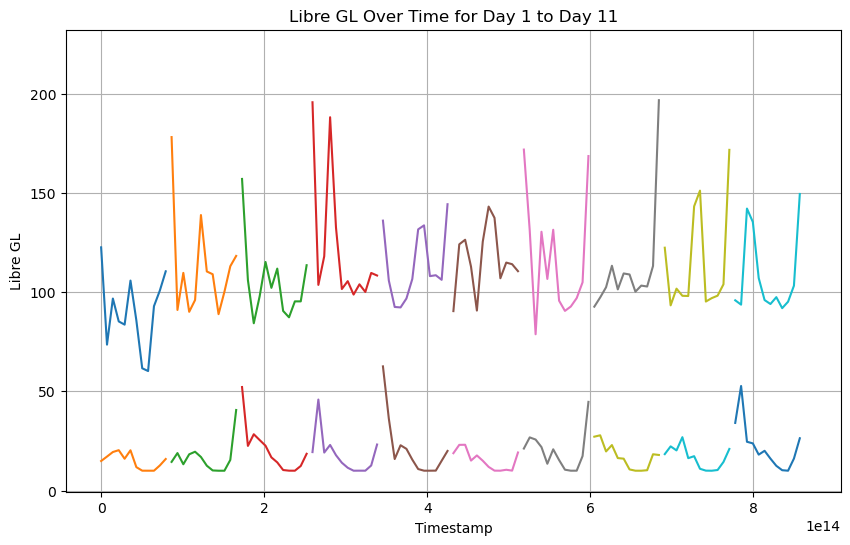

In [116]:
# Libre GL
# reset the time
# find the actual Calories and nutrions based on the percentage of amount consumed

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-005.csv')
particpants_1_data['Timestamp'] = pd.to_datetime(particpants_1_data['Timestamp'])
# reset the time by subtracting the first time
particpants_1_data['Timestamp'] = particpants_1_data['Timestamp'] - particpants_1_data['Timestamp'][0]

# drop Dexcom GL column
particpants_1_data = particpants_1_data.drop(columns=['Dexcom GL'])

# only look at the data in day 1
particpants_1_data_day_1 = particpants_1_data[particpants_1_data['Timestamp'] < pd.Timedelta('1 days')]

# only look at the data in day 2
particpants_1_data_day_2 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('1 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('2 days'))]

# only look at the data in day 3
particpants_1_data_day_3 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('2 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('3 days'))]

# only look at the data in day 4
particpants_1_data_day_4 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('3 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('4 days'))]

# only look at the data in day 5
particpants_1_data_day_5 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('4 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('5 days'))]

# only look at the data in day 6
particpants_1_data_day_6 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('5 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('6 days'))]

# only look at the data in day 7
particpants_1_data_day_7 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('6 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('7 days'))]

# only look at the data in day 8
particpants_1_data_day_8 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('7 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('8 days'))]

# only look at the data in day 9
particpants_1_data_day_9 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('8 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('9 days'))]

# only look at the data in day 10
particpants_1_data_day_10 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('9 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('10 days'))]

# only look at the data in day 11
particpants_1_data_day_11 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('10 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('11 days'))]

# combine time stamps into 10 mins interval and only keep the column Timestamp and Libre GL and drop the rest
particpants_1_data_day1_agg = particpants_1_data_day_1.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day2_agg = particpants_1_data_day_2.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day3_agg = particpants_1_data_day_3.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day4_agg = particpants_1_data_day_4.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day5_agg = particpants_1_data_day_5.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day6_agg = particpants_1_data_day_6.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day7_agg = particpants_1_data_day_7.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day8_agg = particpants_1_data_day_8.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day9_agg = particpants_1_data_day_9.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day10_agg = particpants_1_data_day_10.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day11_agg = particpants_1_data_day_11.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()

# plot the eleven days overlapping on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['Libre GL'], label='Day 1')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['Libre GL'], label='Day 2')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['Libre GL'], label='Day 3')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['Libre GL'], label='Day 4')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['Libre GL'], label='Day 5')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['Libre GL'], label='Day 6')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['Libre GL'], label='Day 7')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['Libre GL'], label='Day 8')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['Libre GL'], label='Day 9')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['Libre GL'], label='Day 10')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['Libre GL'], label='Day 11')

plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['METs'], label='Day 1 METs')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['METs'], label='Day 2 METs')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['METs'], label='Day 3 METs')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['METs'], label='Day 4 METs')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['METs'], label='Day 5 METs')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['METs'], label='Day 6 METs')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['METs'], label='Day 7 METs')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['METs'], label='Day 8 METs')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['METs'], label='Day 9 METs')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['METs'], label='Day 10 METs')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['METs'], label='Day 11 METs')

plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.title('Libre GL Over Time for Day 1 to Day 11')
# plt.legend()
plt.grid(True)
plt.show()


In [120]:
particpants_1_data

,Timestamp,Libre GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed
0,0 days 00:00:00,113.000000,74.0,1.31330,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0 days 00:01:00,111.800000,70.0,1.31330,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0 days 00:02:00,110.600000,73.0,1.31330,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0 days 00:03:00,109.400000,74.0,1.31330,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0 days 00:04:00,108.200000,72.0,1.31330,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
14515,10 days 02:10:00,77.333333,87.0,1.83705,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14516,10 days 02:11:00,77.266667,83.0,1.71458,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14517,10 days 02:12:00,77.200000,83.0,1.83705,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14518,10 days 02:13:00,77.133333,85.0,1.83705,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


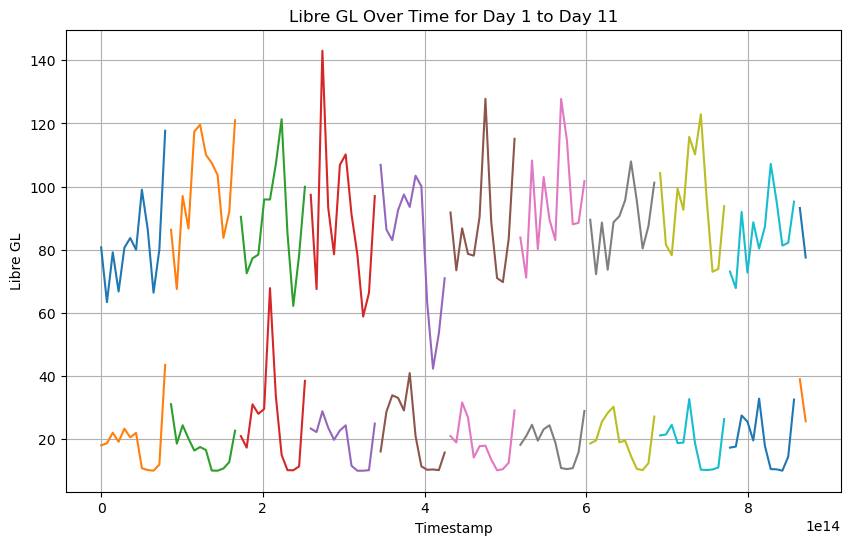

In [121]:
# Libre GL
# reset the time
# find the actual Calories and nutrions based on the percentage of amount consumed

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-043.csv')
particpants_1_data['Timestamp'] = pd.to_datetime(particpants_1_data['Timestamp'])
# reset the time by subtracting the first time
particpants_1_data['Timestamp'] = particpants_1_data['Timestamp'] - particpants_1_data['Timestamp'][0]

# drop Dexcom GL column
particpants_1_data = particpants_1_data.drop(columns=['Dexcom GL'])

# only look at the data in day 1
particpants_1_data_day_1 = particpants_1_data[particpants_1_data['Timestamp'] < pd.Timedelta('1 days')]

# only look at the data in day 2
particpants_1_data_day_2 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('1 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('2 days'))]

# only look at the data in day 3
particpants_1_data_day_3 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('2 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('3 days'))]

# only look at the data in day 4
particpants_1_data_day_4 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('3 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('4 days'))]

# only look at the data in day 5
particpants_1_data_day_5 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('4 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('5 days'))]

# only look at the data in day 6
particpants_1_data_day_6 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('5 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('6 days'))]

# only look at the data in day 7
particpants_1_data_day_7 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('6 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('7 days'))]

# only look at the data in day 8
particpants_1_data_day_8 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('7 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('8 days'))]

# only look at the data in day 9
particpants_1_data_day_9 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('8 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('9 days'))]

# only look at the data in day 10
particpants_1_data_day_10 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('9 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('10 days'))]

# only look at the data in day 11
particpants_1_data_day_11 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('10 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('11 days'))]

# combine time stamps into 10 mins interval and only keep the column Timestamp and Libre GL and drop the rest
particpants_1_data_day1_agg = particpants_1_data_day_1.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day2_agg = particpants_1_data_day_2.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day3_agg = particpants_1_data_day_3.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day4_agg = particpants_1_data_day_4.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day5_agg = particpants_1_data_day_5.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day6_agg = particpants_1_data_day_6.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day7_agg = particpants_1_data_day_7.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day8_agg = particpants_1_data_day_8.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day9_agg = particpants_1_data_day_9.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day10_agg = particpants_1_data_day_10.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day11_agg = particpants_1_data_day_11.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()

# plot the eleven days overlapping on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['Libre GL'], label='Day 1')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['Libre GL'], label='Day 2')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['Libre GL'], label='Day 3')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['Libre GL'], label='Day 4')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['Libre GL'], label='Day 5')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['Libre GL'], label='Day 6')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['Libre GL'], label='Day 7')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['Libre GL'], label='Day 8')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['Libre GL'], label='Day 9')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['Libre GL'], label='Day 10')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['Libre GL'], label='Day 11')

plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['METs'], label='Day 1 METs')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['METs'], label='Day 2 METs')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['METs'], label='Day 3 METs')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['METs'], label='Day 4 METs')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['METs'], label='Day 5 METs')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['METs'], label='Day 6 METs')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['METs'], label='Day 7 METs')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['METs'], label='Day 8 METs')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['METs'], label='Day 9 METs')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['METs'], label='Day 10 METs')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['METs'], label='Day 11 METs')

plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.title('Libre GL Over Time for Day 1 to Day 11')
# plt.legend()
plt.grid(True)
plt.show()


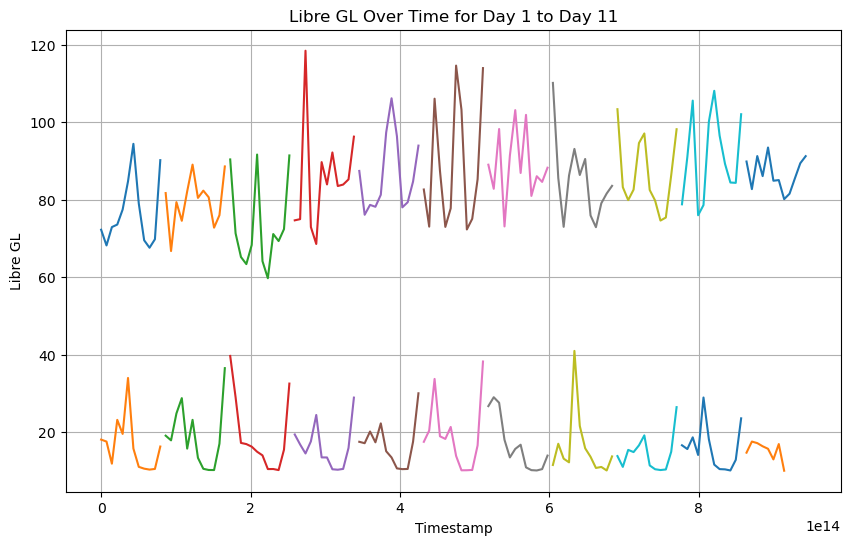

In [122]:
# Libre GL
# reset the time
# find the actual Calories and nutrions based on the percentage of amount consumed

particpants_1_data = pd.read_csv('../cleaned_data/CGMacros-016.csv')
particpants_1_data['Timestamp'] = pd.to_datetime(particpants_1_data['Timestamp'])
# reset the time by subtracting the first time
particpants_1_data['Timestamp'] = particpants_1_data['Timestamp'] - particpants_1_data['Timestamp'][0]

# drop Dexcom GL column
particpants_1_data = particpants_1_data.drop(columns=['Dexcom GL'])

# only look at the data in day 1
particpants_1_data_day_1 = particpants_1_data[particpants_1_data['Timestamp'] < pd.Timedelta('1 days')]

# only look at the data in day 2
particpants_1_data_day_2 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('1 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('2 days'))]

# only look at the data in day 3
particpants_1_data_day_3 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('2 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('3 days'))]

# only look at the data in day 4
particpants_1_data_day_4 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('3 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('4 days'))]

# only look at the data in day 5
particpants_1_data_day_5 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('4 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('5 days'))]

# only look at the data in day 6
particpants_1_data_day_6 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('5 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('6 days'))]

# only look at the data in day 7
particpants_1_data_day_7 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('6 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('7 days'))]

# only look at the data in day 8
particpants_1_data_day_8 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('7 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('8 days'))]

# only look at the data in day 9
particpants_1_data_day_9 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('8 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('9 days'))]

# only look at the data in day 10
particpants_1_data_day_10 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('9 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('10 days'))]

# only look at the data in day 11
particpants_1_data_day_11 = particpants_1_data[(particpants_1_data['Timestamp'] >= pd.Timedelta('10 days')) & (particpants_1_data['Timestamp'] < pd.Timedelta('11 days'))]

# combine time stamps into 10 mins interval and only keep the column Timestamp and Libre GL and drop the rest
particpants_1_data_day1_agg = particpants_1_data_day_1.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day2_agg = particpants_1_data_day_2.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day3_agg = particpants_1_data_day_3.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day4_agg = particpants_1_data_day_4.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day5_agg = particpants_1_data_day_5.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day6_agg = particpants_1_data_day_6.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day7_agg = particpants_1_data_day_7.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day8_agg = particpants_1_data_day_8.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day9_agg = particpants_1_data_day_9.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day10_agg = particpants_1_data_day_10.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()
particpants_1_data_day11_agg = particpants_1_data_day_11.groupby(pd.Grouper(key='Timestamp', freq='120T'))[['Libre GL', 'METs']].mean().reset_index()

# plot the eleven days overlapping on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['Libre GL'], label='Day 1')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['Libre GL'], label='Day 2')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['Libre GL'], label='Day 3')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['Libre GL'], label='Day 4')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['Libre GL'], label='Day 5')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['Libre GL'], label='Day 6')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['Libre GL'], label='Day 7')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['Libre GL'], label='Day 8')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['Libre GL'], label='Day 9')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['Libre GL'], label='Day 10')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['Libre GL'], label='Day 11')

plt.plot(particpants_1_data_day1_agg['Timestamp'], particpants_1_data_day1_agg['METs'], label='Day 1 METs')
plt.plot(particpants_1_data_day2_agg['Timestamp'], particpants_1_data_day2_agg['METs'], label='Day 2 METs')
plt.plot(particpants_1_data_day3_agg['Timestamp'], particpants_1_data_day3_agg['METs'], label='Day 3 METs')
plt.plot(particpants_1_data_day4_agg['Timestamp'], particpants_1_data_day4_agg['METs'], label='Day 4 METs')
plt.plot(particpants_1_data_day5_agg['Timestamp'], particpants_1_data_day5_agg['METs'], label='Day 5 METs')
plt.plot(particpants_1_data_day6_agg['Timestamp'], particpants_1_data_day6_agg['METs'], label='Day 6 METs')
plt.plot(particpants_1_data_day7_agg['Timestamp'], particpants_1_data_day7_agg['METs'], label='Day 7 METs')
plt.plot(particpants_1_data_day8_agg['Timestamp'], particpants_1_data_day8_agg['METs'], label='Day 8 METs')
plt.plot(particpants_1_data_day9_agg['Timestamp'], particpants_1_data_day9_agg['METs'], label='Day 9 METs')
plt.plot(particpants_1_data_day10_agg['Timestamp'], particpants_1_data_day10_agg['METs'], label='Day 10 METs')
plt.plot(particpants_1_data_day11_agg['Timestamp'], particpants_1_data_day11_agg['METs'], label='Day 11 METs')

plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.title('Libre GL Over Time for Day 1 to Day 11')
# plt.legend()
plt.grid(True)
plt.show()


<AxesSubplot:xlabel='Timestamp'>

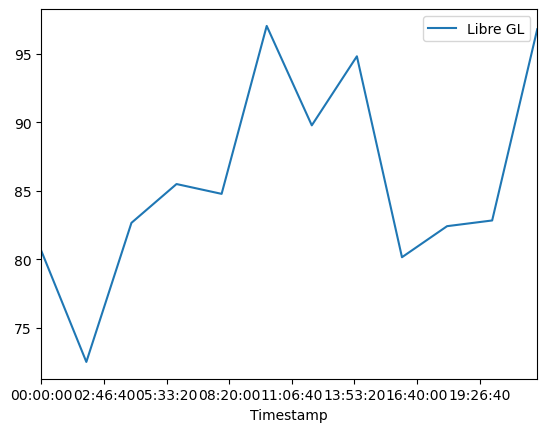

In [79]:
particpants_1_data.plot(x='Timestamp', y='Libre GL', kind='line')

In [ ]:
# find the row that has value in the Meal Type column
meal_type = particpants_1_data['Meal Type'].dropna()
meal_type = meal_type.index

particpants_1_data[particpants_1_data['Meal Type'].notnull()]

,Timestamp,Libre GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed
233,0 days 03:53:00,69.800000,95.0,4.61296,44.0,Lunch,1170.0,85.0,88.0,54.2,12.0,100.0
618,0 days 10:18:00,84.800000,81.0,1.36292,13.0,Dinner,80.0,18.0,0.0,0.0,0.0,100.0
825,0 days 13:45:00,81.000000,78.0,4.40328,42.0,Snacks,110.0,24.0,0.0,2.0,0.0,100.0
1308,0 days 21:48:00,88.400000,81.0,3.14520,30.0,Breakfast,448.0,66.0,22.0,10.5,0.0,100.0
1530,1 days 01:30:00,82.000000,84.0,2.93552,28.0,Lunch,840.0,89.0,17.0,42.0,3.0,100.0
1807,1 days 06:07:00,95.133333,81.0,2.93552,28.0,Snacks,38.0,9.0,0.0,0.0,0.0,100.0
2002,1 days 09:22:00,94.266667,88.0,3.56456,34.0,Dinner,330.0,32.0,4.0,22.0,4.0,100.0
2253,1 days 13:33:00,90.400000,81.0,1.36292,13.0,Snacks,160.0,29.0,2.0,4.0,0.0,100.0
2797,1 days 22:37:00,86.266667,93.0,1.57260,15.0,Breakfast,608.0,66.0,66.0,10.5,0.0,100.0
3141,2 days 04:21:00,79.000000,96.0,2.72584,26.0,Lunch,615.0,26.0,67.0,30.0,3.0,100.0


# Data Cleaning Schema

## bio.csv
- rename the column
- check the missing value
- check the distribution of the data

In [11]:
df = pd.read_csv('../cleaned_data/CGMacros-001.csv.csv')

In [4]:
gemographic_data = pd.read_csv('../data/CGMacros/bio.csv')
gemographic_data.columns

gut_health_data = pd.read_csv('../data/CGMacros/gut_health_test.csv')

In [8]:
gut_health_data

gut_health_data.rename(columns={'subject': 'PID'}, inplace=False).columns


Index(['PID', 'Gut Lining Health', 'LPS Biosynthesis Pathways',
       'Biofilm, Chemotaxis, and Virulence Pathways',
       'TMA Production Pathways', 'Ammonia Production Pathways',
       'Metabolic Fitness', 'Active Microbial Diversity',
       'Butyrate Production Pathways', 'Flagellar Assembly Pathways',
       'Putrescine Production Pathways', 'Uric Acid Production Pathways',
       'Bile Acid Metabolism Pathways', 'Inflammatory Activity',
       'Gut Microbiome Health', 'Digestive Efficiency', 'Protein Fermentation',
       'Gas Production', 'Methane Gas Production Pathways',
       'Sulfide Gas Production Pathways', 'Oxalate Metabolism Pathways',
       'Salt Stress Pathways', 'Microbiome-Induced Stress'],
      dtype='object')

In [23]:
# rename the some of the column name 
gemographic_data.rename(columns={'subject': 'PID', 'Self-identify ': 'Self-identifid-Race'}, inplace=True)

# aggregre the starting GLU by taking the average of three
gemographic_data['Starting GLU'] = gemographic_data[['#1 Contour Fingerstick GLU', ' #2 Contour Fingerstick GLU', '#3 Contour Fingerstick GLU']].mean(axis=1)
gemographic_data.drop(['#1 Contour Fingerstick GLU', ' #2 Contour Fingerstick GLU', '#3 Contour Fingerstick GLU', 'Time (t)', 'Time (t).1', 'Time (t).2'], axis=1, inplace=True)

In [24]:
gemographic_data

,PID,Age,Gender,BMI,Body weight,Height,Self-identifid-Race,A1c PDL (Lab),Fasting GLU - PDL (Lab),Insulin,Triglycerides,Cholesterol,HDL,Non HDL,LDL (Cal),VLDL (Cal),Cho/HDL Ratio,Collection time PDL (Lab),Starting GLU
0,1,27,M,22.265239,133.8,65.00,Hispanic/Latino,5.4,91,2.5,67,216,74,142,130,13,2.9,11:06:00 AM,81.000000
1,2,49,F,30.946742,169.2,62.00,Hispanic/Latino,5.5,93,14.8,61,181,91,90,78,12,2.0,7:38:00 AM,98.000000
2,3,59,F,26.948690,157.0,64.00,Hispanic/Latino,6.5,118,17.4,154,190,74,116,90,31,2.6,7:25:00 AM,127.666667
3,4,33,F,42.384279,262.6,66.00,Hispanic/Latino,5.5,105,19.4,300,267,46,221,164,60,5.8,7:20:00 AM,103.000000
4,5,51,F,30.957534,172.0,62.50,Hispanic/Latino,6.6,144,12.9,392,269,38,231,157,78,7.1,7:45:00 AM,161.333333
5,6,51,F,29.303451,197.0,68.75,White,5.2,96,6.4,75,203,72,131,118,15,2.8,7:45:00 AM,88.333333
6,7,66,F,27.070327,199.6,72.00,Hispanic/Latino,5.9,108,15.9,92,128,43,85,67,18,3.0,8:00:00 AM,122.333333
7,8,54,M,39.945440,218.4,62.00,Hispanic/Latino,5.8,112,17.7,145,180,60,120,95,29,3.0,8:55:00 AM,120.000000
8,9,34,F,37.001506,183.2,59.00,Hispanic/Latino,5.7,122,25.7,312,202,40,162,108,62,5.1,7:32:00 AM,114.333333
9,10,54,F,35.811892,195.8,62.00,Hispanic/Latino,5.7,100,15.3,101,183,55,128,110,20,3.3,7:44:00 AM,122.666667


In [18]:
# cleaning
## drop na value in the gut_health_test_data



# importing data
gemographic_data = pd.read_csv('../data/CGMacros/bio.csv')
gut_health_test_data = pd.read_csv('../data/CGMacros/gut_health_test.csv')
microbes_data = pd.read_csv('../data/CGMacros/microbes.csv')

sample_cgmacros_data = pd.read_csv('../data/CGMacros/CGMacros-001/CGMacros-001.csv')
sample_cgmacros_data = sample_cgmacros_data.drop(columns=['Unnamed: 0'])

In [19]:
sample_cgmacros_data

,Timestamp,Libre GL,Dexcom GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,Image path
0,2020-05-01 10:30:00,84.000000,NaN,56.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-01 10:31:00,84.133333,NaN,56.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-01 10:32:00,84.266667,NaN,57.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-01 10:33:00,84.400000,NaN,54.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-01 10:34:00,84.533333,NaN,55.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14725,2020-05-11 15:55:00,81.666667,NaN,78.0,2.93552,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14726,2020-05-11 15:56:00,81.733333,NaN,79.0,3.14520,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14727,2020-05-11 15:57:00,81.800000,NaN,80.0,3.56456,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14728,2020-05-11 15:58:00,81.866667,NaN,81.0,3.56456,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NameError: name 'plot' is not defined

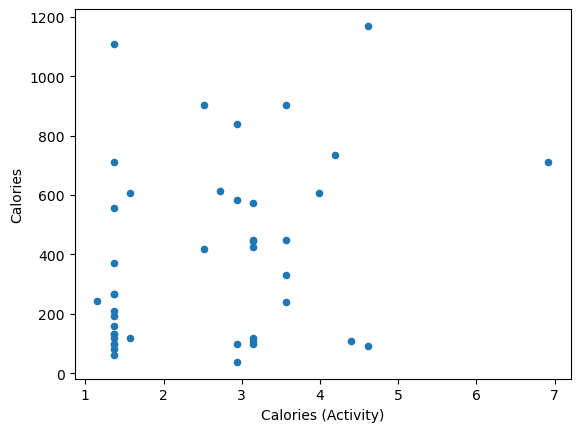

In [20]:
# find the average calore input for sample_cgmacros_data in each meal type

meal = sample_cgmacros_data.dropna(subset=['Calories (Activity)', 'Calories'])

# make a scater plot where the x-axis is the calories in the activity and the y-axis is the calories in the meal
meal.plot.scatter(x='Calories (Activity)', y='Calories')

plot.title('Calories burned in Activity vs Calories in Meal')

In [ ]:
# plot the change of the calories consumption in each data acorss time

meal = sample_cgmacros_data.dropna(subset=['Calories (Activity)', 'Calories'])



# convert the timestamp to datetime
sample_cgmacros_data['Timestamp'] = pd.to_datetime(sample_cgmacros_data['Timestamp'])

sample_cgmacros_data = sample_cgmacros_data.dropna(subset=['Calories'])




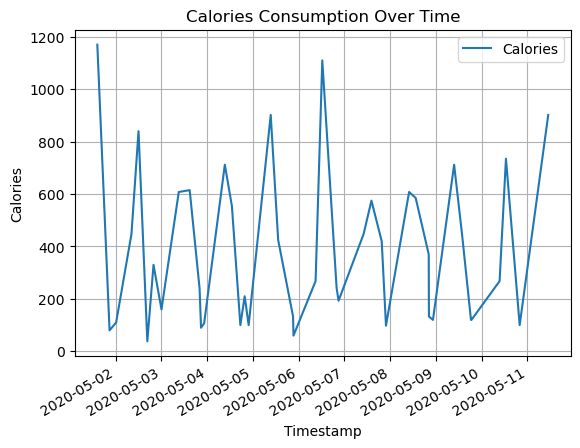

In [ ]:
# plot the change of the calories consumption in each data across time
ax = sample_cgmacros_data.plot(x='Timestamp', y='Calories', title='Calories Consumption Over Time')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Calories')
ax.grid(True)

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_72207/1505689501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_cgmacros_data['Date'] = sample_cgmacros_data['Timestamp'].dt.date


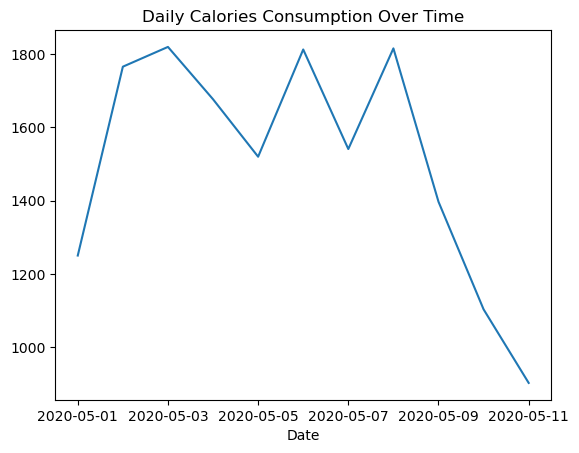

In [ ]:
# make another plot visualizing the calories consumption per day 
# (sum of calories in each day) across time
sample_cgmacros_data['Date'] = sample_cgmacros_data['Timestamp'].dt.date
daily_calories = sample_cgmacros_data.groupby('Date')['Calories'].sum()
daily_calories.plot(title='Daily Calories Consumption Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Calories')
ax.grid(True)

# # make a overlapping plot where the x-axis is the timestamp and the y-axis is the calories burned per day
# sample_cgmacros_data['Date'] = sample_cgmacros_data['Timestamp'].dt.date
# daily_burned_calories = sample_cgmacros_data.groupby('Date')['Calories (Activity)'].sum()
# daily_burned_calories.plot(title='Daily Calories Burned Over Time')
# ax.set_xlabel('Date')

In [ ]:
daily_burned_calories

Date
2020-05-01     5.97588
2020-05-02    16.98408
2020-05-03    16.98408
2020-05-04    14.15340
2020-05-05     9.43560
2020-05-06     5.24200
2020-05-07    12.16144
2020-05-08    12.79048
2020-05-09     7.44364
2020-05-10     6.91944
2020-05-11     2.51616
Name: Calories (Activity), dtype: float64

In [ ]:
sample_cgmacros_data['Calories']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
14725   NaN
14726   NaN
14727   NaN
14728   NaN
14729   NaN
Name: Calories, Length: 14730, dtype: float64

In [ ]:
sample_cgmacros_data

# find 

,Timestamp,Libre GL,Dexcom GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,Image path
0,2020-05-01 10:30:00,84.000000,NaN,56.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-01 10:31:00,84.133333,NaN,56.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-01 10:32:00,84.266667,NaN,57.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-01 10:33:00,84.400000,NaN,54.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-01 10:34:00,84.533333,NaN,55.0,1.04840,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14725,2020-05-11 15:55:00,81.666667,NaN,78.0,2.93552,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14726,2020-05-11 15:56:00,81.733333,NaN,79.0,3.14520,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14727,2020-05-11 15:57:00,81.800000,NaN,80.0,3.56456,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14728,2020-05-11 15:58:00,81.866667,NaN,81.0,3.56456,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# identify the microbes that appear the most among participants in the microbes data set

microb_existence = microbes_data.set_index('subject').sum(axis=0).sort_values(ascending=False)

# top 5 microbes that appear the most among participants in the microbes data set
top5_microbes = microb_existence.head(5)

# find the microbes that are most likely to appear together with the top 5 microbes
co_occurrence = microbes_data[top5_microbes.index].T.dot(microbes_data)
co_occurrence = co_occurrence.sum(axis=0).sort_values(ascending=False)

# # Exclude the top 5 microbes from the co-occurrence results
# co_occurrence = co_occurrence.drop(top5_microbes.index)

# # Display the microbes that are most likely to appear together with the top 5 microbes
# co_occurrence.head()

In [ ]:
gemographic_data

Index(['subject', 'Age', 'Gender', 'BMI', 'Body weight ', 'Height ',
       'Self-identify ', 'A1c PDL (Lab)', 'Fasting GLU - PDL (Lab)',
       'Insulin ', 'Triglycerides', 'Cholesterol', 'HDL', 'Non HDL ',
       'LDL (Cal)', 'VLDL (Cal)', 'Cho/HDL Ratio', 'Collection time PDL (Lab)',
       '#1 Contour Fingerstick GLU', 'Time (t)', ' #2 Contour Fingerstick GLU',
       'Time (t).1', '#3 Contour Fingerstick GLU', 'Time (t).2'],
      dtype='object')